In [1]:
library(data.table)
library(ggplot2)
# library(hrbrthemes)
library(reshape2)
library(tidyverse)
library(stringr)
library(heatmaply)
library(ape)
library(phylogram)
library(dendextend)
library(ComplexHeatmap)
library(RColorBrewer)
library(circlize)
library(ggpubr)
library(scales)
library(gridExtra)
theme_set(theme_bw())


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: plotly


Attaching package: ‘plotly’


The f

In [2]:
mflorens_hits <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/mflorens_hits.tsv")
nrow(mflorens_hits[coverage >= 3, .N, by=sample][N >= 10])

bog38_hits <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/bog38_genus_hits.tsv")
nrow(bog38_hits[coverage >= 5, .N, by=sample][N >= 10])

[1] 135

[1] 225

In [6]:
nrow(bog38_hits[, .N, by=sample])

[1] 17005

In [3]:
write.table(
    mflorens_hits[coverage >= 10], 
    file = "/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/mflorens_hits_cov_10.tsv", 
    quote = FALSE, 
    row.names = FALSE,
    sep = "\t"
)

write.table(
    mflorens_hits[coverage >= 5, .N, by=sample][N >= 10]$sample, 
    file = "/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/mflorens_hits_cov_10_sample_names.txt", 
    quote = FALSE, 
    row.names = FALSE,
    col.names = FALSE,
    sep = "\t"
)

write.table(
    bog38_hits[coverage >= 10], 
    file = "/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/bog38_hits_cov_10.tsv", 
    quote = FALSE, 
    row.names = FALSE,
    sep = "\t"
)

write.table(
    bog38_hits[coverage >= 5, .N, by=sample][N >= 10]$sample, 
    file = "/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/bog38_hits_cov_10_sample_names.txt", 
    quote = FALSE, 
    row.names = FALSE,
    col.names = FALSE,
    sep = "\t"
)

Warning message in file(file, ifelse(append, "a", "w")):
“cannot open file '/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/mflorens_hits_cov_10.tsv': No such file or directory”


ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection


In [330]:
tstrsplit("/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03-lorikeet_out/GCA_003139855.1_20110800_S2M_genomic/", "/", keep=9L)

[[1]]
[1] "GCA_003139855.1_20110800_S2M_genomic"

In [2]:
get_ani <- function(
    path="/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03-lorikeet_out/GCA_003139855.1_20110800_S2M_genomic/", 
    full_metadata=full_metadata, 
    coverages=mflorens_coverage_m,
    breadth=mflorens_breadth_m
) {
    ###
    #Takes full path to lorikeet output folder for given genome
    #full_metadata is generated below, and coverages should be read in automatically.
    #You will just need to change the file paths to the corresponding files for you
    ###
    
    suffix = tstrsplit(path, "/", keep=10L)
    pop_ani <- fread(paste0(path, "/", suffix, "_population_ani.tsv"), skip="SampleID",)
    con_ani <- fread(paste0(path, "/", suffix, "_consensus_ani.tsv"), skip="SampleID",)
    sub_pop_ani <- fread(paste0(path, "/", suffix, "_subpopulation_ani.tsv"), skip="SampleID",)
    fst <- fread(paste0(path, "/", suffix, "_sample_fst_values.tsv"), skip="SampleID",)

    # sample_labels
    con_ani[, SampleID:=factor(SampleID)]
    joined_con_ani <- full_join(con_ani, full_metadata, by=c("SampleID"))
    joined_con_ani <- full_join(joined_con_ani, coverages, by=c("run"="variable"))
    joined_con_ani <- full_join(joined_con_ani, breadth, by=c("run"="variable"))
    joined_con_ani[, sample_name_fixed := ifelse(is.na(sample_name), V1, sample_name)]
    joined_con_ani[, log10_abundance:=scale(value)]
    joined_con_ani[, taxon_name:=ifelse(taxon_name=="NA", NA, taxon_name)]
    # joined_con_ani[, location:=ifelse(location=="NA", NA, location)]
    # joined_con_ani[, type:=ifelse(type=="NA", NA, type)]
    
    pop_ani[, SampleID:=factor(SampleID)]
    
    joined_pop_ani <- full_join(pop_ani, full_metadata, by=c("SampleID"))
    joined_pop_ani <- full_join(joined_pop_ani, coverages, by=c("run"="variable"))
    joined_pop_ani <- full_join(joined_pop_ani, breadth, by=c("run"="variable"))
    joined_pop_ani[, sample_name_fixed := ifelse(is.na(sample_name), V1, sample_name)]
    joined_pop_ani[, log10_abundance:=log10(value)]
    
    joined_pop_ani[, taxon_name:=ifelse(taxon_name=="NA", NA, taxon_name)]
    # joined_pop_ani[, location:=ifelse(location=="NA", NA, location)]
    # joined_pop_ani[, type:=ifelse(type=="NA", NA, type)]
    
    sub_pop_ani[, SampleID:=factor(SampleID)]
    joined_sub_pop_ani <- full_join(sub_pop_ani, full_metadata, by=c("SampleID"))
    joined_sub_pop_ani <- full_join(joined_sub_pop_ani, coverages, by=c("run"="variable"))
    joined_sub_pop_ani <- full_join(joined_sub_pop_ani, breadth, by=c("run"="variable"))
    joined_sub_pop_ani[, sample_name_fixed := ifelse(is.na(sample_name), V1, sample_name)]
    joined_sub_pop_ani[, log10_abundance:=log10(value)]
    
    joined_sub_pop_ani[, taxon_name:=ifelse(taxon_name=="NA", NA, taxon_name)]
    # joined_sub_pop_ani[, location:=ifelse(location=="NA", NA, location)]
    # joined_sub_pop_ani[, type:=ifelse(type=="NA", NA, type)]

    fst[, SampleID:=factor(SampleID)]
    joined_fst <- full_join(fst, full_metadata, by=c("SampleID"))
    joined_fst<- full_join(joined_fst, coverages, by=c("run"="variable"))
    joined_fst<- full_join(joined_fst, breadth, by=c("run"="variable"))
    joined_fst[, sample_name_fixed := ifelse(is.na(sample_name), V1, sample_name)]
    joined_fst[, log10_abundance:=log10(value)]
    
    joined_fst[, taxon_name:=ifelse(taxon_name=="NA", NA, taxon_name)]
    # joined_fst[, location:=ifelse(location=="NA", NA, location)]
    # joined_fst[, type:=ifelse(type=="NA", NA, type)]
    
    return(list(con=joined_con_ani, pop=joined_pop_ani, sub_pop=joined_sub_pop_ani, fst=joined_fst))
}

In [3]:
header <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03.3-lorikeet_fst/GCA_003139855.1_20110800_S2M_genomic/GCA_003139855.1_20110800_S2M_genomic_population_ani.tsv")
metadata <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/bog38_sample_annotations.txt")[run != "-----------"]
metadata[, location:=ifelse(grepl("\\.NA", sample_name, fixed=F) | startsWith(sample_name, "20120700"), "Abisko", 
                                  ifelse(startsWith(sample_name, "G") & taxon_name=="peat metagenome" | startsWith(sample_name, "MG_"), "Marcell", 
                                     ifelse(startsWith(sample_name, "G"), "Loxahatchee", 
                                            ifelse(sample_name=="Metagenome", "Chersky", 
                                                   ifelse(grepl("AK5YR", sample_name, fixed=F), "Alaska", 
                                                          ifelse(startsWith(sample_name, "S1071") | startsWith(sample_name, "BPON"), "Alaska", 
                                                                 ifelse(model=="NextSeq 500", "Abisko", 
                                                                        "Other")))))))]
metadata[, taxon_name:=str_replace(taxon_name, " metagenome", "")]
metadata[, taxon_name:=str_replace(taxon_name, "sediment", "sdmnt.")]
metadata[, type:=ifelse(location=='Abisko', ifelse(
    grepl('_E', sample_name, fixed=F), 'Fen', ifelse(grepl('_S', sample_name, fixed=F), 'Bog', ifelse(grepl('_P', sample_name, fixed=F), 'Palsa', 'Other'))), 'Other')]

header[, V1:=str_replace(V1, "##sample=<ID=", "")]
header[, run:=str_replace(`##source=lorikeet-v0.7.2`, "name=04-bams/coverm-genome\\.", "")]
header[, `##source=lorikeet-v0.7.2`:=NULL]
header[, run:=str_replace(run, "_1\\.fastq\\.gz\\.bam>", "")]
header[, run:=str_replace(run, "_1\\.fastq\\.bam>", "")]

# header$`##source=lorikeet-v0.6.1` = NULL
full_metadata <- full_join(metadata, header, by.x="run", by.y="run")
full_metadata$location <- full_metadata$location %>% replace_na('Other')
full_metadata$type <- full_metadata$type %>% replace_na('Other')
full_metadata$type <- factor(full_metadata$type, level=c("Bog", "Fen", "Palsa", "Other"))
# print(full_metadata$type)
mflorens_coverage <- fread("//mnt/hpccs01//scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/bog_coverage_and_abundances.tsv")

mflorens_coverage_m <- as.data.table(melt(mflorens_coverage))
mflorens_coverage_m <- mflorens_coverage_m[grepl("Trimmed", variable)]
mflorens_coverage_m[, variable:=gsub("_1..*", "", variable)]
mflorens_coverage_m[, variable:=gsub("coverm-genome\\.", "", variable)]
mflorens_breadth_m <- as.data.table(melt(mflorens_coverage))
mflorens_breadth_m <- mflorens_breadth_m[grepl("Covered", variable)]
mflorens_breadth_m[, variable:=gsub("_1..*", "", variable)]
mflorens_breadth_m[, variable:=gsub("coverm-genome\\.", "", variable)]
mflorens_breadth_m[, fraction:=value]
mflorens_breadth_m[, value:=NULL]

full_metadata[, SampleID:=factor(V1)]

bog38 <- get_ani("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03.3-lorikeet_fst/GCA_003139855.1_20110800_S2M_genomic/", full_metadata=full_metadata, coverages=mflorens_coverage_m[Genome=="GCA_003139855.1_20110800_S2M_genomic"], breadth=mflorens_breadth_m[Genome=="GCA_003139855.1_20110800_S2M_genomic"])
fen3 <- get_ani("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03.3-lorikeet_fst/GCA_003162175.1_20100900_E2D_genomic/", full_metadata=full_metadata, coverages=mflorens_coverage_m[Genome=="GCA_003162175.1_20100900_E2D_genomic"], breadth=mflorens_breadth_m[Genome=="GCA_003162175.1_20100900_E2D_genomic"])
fen53 <- get_ani("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03.3-lorikeet_fst/GCA_003158275.1_20120600_E3D_genomic/", full_metadata=full_metadata, coverages=mflorens_coverage_m[Genome=="GCA_003158275.1_20120600_E3D_genomic"], breadth=mflorens_breadth_m[Genome=="GCA_003158275.1_20120600_E3D_genomic"])

Warning message in fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03.3-lorikeet_fst/GCA_003139855.1_20110800_S2M_genomic/GCA_003139855.1_20110800_S2M_genomic_population_ani.tsv"):
“Detected 1 column names but the data has 2 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03.3-lorikeet_fst/GCA_003139855.1_20110800_S2M_genomic/GCA_003139855.1_20110800_S2M_genomic_population_ani.tsv"):
“Stopped early on line 210. Expected 2 fields but found 1. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<SampleID  	1       	2       	3       	4       	5       	6       	7       	8       	9       	10      	11     

In [30]:
bog38$con$type

[1] Other Other Other Other Other Other Other Other Other Other Other Other
 [13] Other Other Other Other Other Other Other Other Other Other Other Other
 [25] Other Other Other Other Other Other Other Other Other Other Other Other
 [37] Other Other Other Other Other Other Other Other Other Other Other Other
 [49] Other Other Other Other Other Other Other Other Other Other Other Other
 [61] Other Other Other Other Other Other Other Other Other Other Other Other
 [73] Other Other Other Other Other Other Other Other Other Other Other Other
 [85] Other Other Other Other Other Other Other Other Other Other Other Other
 [97] Other Other Other Other Other Other Other Other Other Other Other Other
[109] Other Other Other Other Other Other Other Other Other Other Other Other
[121] Other Other Other Other Other Other Other Other Fen   Bog   Bog   Bog  
[133] Fen   Fen   Fen   Fen   Fen   Fen   Fen   Fen   Bog   Bog   Bog   Bog  
[145] Bog   Palsa Palsa Bog   Bog   Bog   Fen   Bog   Fen   Fen   Fen   Fen  
[157] Fen   Fen   Fen   Fen   Fen   Fen   Fen   Fen   Fen   Fen   Fen   Fen  
[169] Fen   Fen   Fen   Bog   Bog   Bog   Bog   Fen   Fen   Fen   Fen   Bog  
[181] Fen   Fen   Bog   Fen   Bog   Bog   Bog   Fen   Bog   Bog   Fen   Fen  
[193] Fen   Bog   Fen   Fen   Fen   Fen   Fen   Fen   Bog   Fen   Bog   Fen  
[205] Other Other Other Other Other Other Other Other Other Other Other Other
[217] Other Other Other Other Other Other Other Other Bog  
Levels: Bog Fen Palsa Other

In [232]:
marcell_sample <- full_metadata[!is.na(location) & location == "Marcell"]
write.table(marcell_sample, "/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/marcell_samples.tsv", sep="\t", row.names=F, quote=F)

In [67]:
write.table(bog38$con[!is.na(`1`), c(seq(210, 219)), with=F], "mflorens_sample_metadata.tsv", sep="\t", row.names=F, quote=F)

In [149]:
# samples per location and total number of Gbp
print(metadata[, .N, by=location])
print(metadata[, sum(as.numeric(Gbp))]) # 3.3 Tbp is massive (2022)

      location  N
1:      Alaska 20
2:       Other 19
3:     Chersky 17
4:     Marcell 47
5: Loxahatchee 13
6:      Abisko 83
[1] 3349.645


In [191]:
cov_and_breadth <- as.data.table(inner_join(mflorens_coverage_m, mflorens_breadth_m))
# cov_and_breadth
(208 - nrow(cov_and_breadth[Genome=="GCA_003139855.1_20110800_S2M_genomic" & (value < 5 | fraction < 0.5)])) / 208
nrow(cov_and_breadth[Genome=="GCA_003139855.1_20110800_S2M_genomic" & (value >= 0.1 & fraction >= 0.15)])
149/208

Joining, by = c("Genome", "variable")


[1] 0.3701923

[1] 159

[1] 0.7163462

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



[1] 0.8603273



Model fitted: Log-logistic (ED50 as parameter) (4 parms)

Parameter estimates:

                Estimate Std. Error    t-value   p-value    
b:(Intercept) 1.6702e+00 1.8054e-01     9.2513 < 2.2e-16 ***
c:(Intercept) 9.9852e-01 3.9354e-05 25372.6405 < 2.2e-16 ***
d:(Intercept) 1.0000e+00 2.9697e-05 33673.5893 < 2.2e-16 ***
e:(Intercept) 3.2147e+00 2.3203e-01    13.8545 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error:

 0.000248038 (204 degrees of freedom)

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


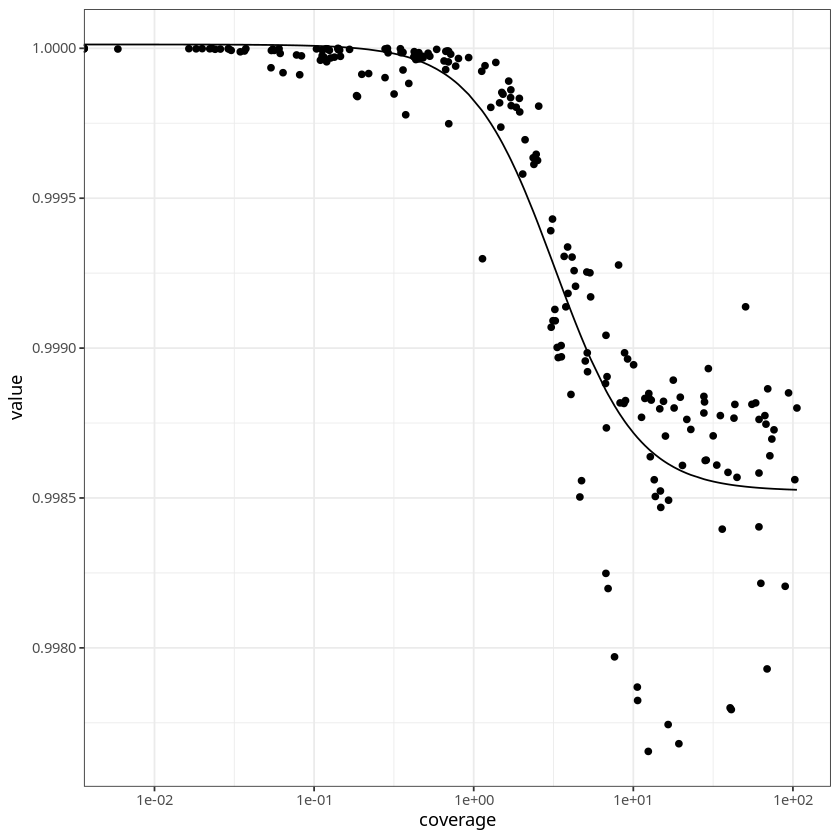

In [113]:
library(drc)
to_select=seq(1,208)
con <- as.matrix(bog38$con[to_select, to_select + 1, with=FALSE])
pop <- as.matrix(bog38$pop[to_select, to_select + 1, with=FALSE])
sub_pop <- as.matrix(bog38$sub_pop[to_select, to_select + 1, with=FALSE])
fst <- as.matrix(bog38$fst[to_select, to_select + 1, with=FALSE])

con[is.infinite(con)] <- 1
pop[is.infinite(pop)] <- 1
sub_pop[is.infinite(sub_pop)] <- 1
fst[is.infinite(fst)] <- 1

con[is.nan(con)] <- 1
pop[is.nan(pop)] <- 1
sub_pop[is.nan(sub_pop)] <- 1
fst[is.nan(fst)] <- 1

con <- melt(as.data.table(con)[, lapply(.SD, mean)])
pop <- melt(as.data.table(pop)[, lapply(.SD, mean)])
sub_pop <- melt(as.data.table(sub_pop)[, lapply(.SD, mean)])
fst <- melt(as.data.table(fst)[, lapply(.SD, mean)])
plot_data <- data.table(sample=con$variable, con_ani=con$value, pop_ani=pop$value, sub_pop_ani=sub_pop$value, fst=fst$value, coverage=bog38$con$value[to_select], fraction=bog38$con$fraction[to_select])
plot_data_m <- data.table(melt(plot_data, id.vars=c("sample", "coverage", "fraction")))
# print(plot_data_m)
fit <- drm(plot_data_m[variable=='con_ani']$value ~ plot_data_m[variable=='con_ani']$coverage, fct=LL.4())
# fit <- lm(plot_data_m[variable=='con_ani']$value ~ plot_data_m[variable=='con_ani']$coverage)
print(cor(plot_data_m[variable=='con_ani']$value, predict(fit))^2)
fit$v <- predict(fit)
fit$coverage = log10(plot_data_m[variable=='con_ani']$coverage + 0.00001)
summary(fit)
ggplot(data=plot_data_m[variable=='con_ani']) + 
    geom_point(aes(x=coverage, y=value)) +
    geom_line(aes(x=coverage, y=predict(fit))) +
    scale_x_log10()

In [118]:
test <- data.table(value = con$value, location = bog38$con[to_select, ]$location)

print(min(test[location != 'Abisko' & location != 'Marcell', ]$value))
print(max(test[location != 'Abisko' & location != 'Marcell', ]$value))

[1] 0.9989316
[1] 1


In [31]:
# # joined_con_ani$sample_name_fixed
# tmp <-ggheatmap(mflorens$con[seq(2, 208), seq(2, 208), with=FALSE],
#                 scale="none",
# #                   xlab = "Sample Name",
# #                   ylab = "Sample Name",
# #                   labRow = joined_con_ani[!is.na(V1)]$sample_name_fixed,
# #                   labCol = joined_con_ani[!is.na(V1)]$sample_name_fixed,
# #                   file = "mflorens_con_ani_heatmap.html",
#                   k_row = 1, k_col = 1)

metric_vs_coverage <- function(input_table, to_select=seq(1,208), title="GCA_003139855.1 (Bog38)") {
    con <- as.matrix(input_table$con[to_select, to_select + 1, with=FALSE])
    pop <- as.matrix(input_table$pop[to_select, to_select + 1, with=FALSE])
    sub_pop <- as.matrix(input_table$sub_pop[to_select, to_select + 1, with=FALSE])
    fst <- as.matrix(input_table$fst[to_select, to_select + 1, with=FALSE])

    con[is.infinite(con)] <- 1
    pop[is.infinite(pop)] <- 1
    sub_pop[is.infinite(sub_pop)] <- 1
    fst[is.infinite(fst)] <- 1

    con[is.nan(con)] <- 1
    pop[is.nan(pop)] <- 1
    sub_pop[is.nan(sub_pop)] <- 1
    fst[is.nan(fst)] <- 1

    con <- con * 100
    pop <- pop * 100
    sub_pop <- sub_pop * 100

    con <- melt(as.data.table(con)[, lapply(.SD, mean)])
    pop <- melt(as.data.table(pop)[, lapply(.SD, mean)])
    sub_pop <- melt(as.data.table(sub_pop)[, lapply(.SD, mean)])
    fst <- melt(as.data.table(fst)[, lapply(.SD, mean)])
    plot_data <- data.table(sample=con$variable, con_ani=con$value, pop_ani=pop$value, sub_pop_ani=sub_pop$value, fst=fst$value, coverage=input_table$con$value[to_select], fraction=input_table$con$fraction[to_select])
    plot_data_m <- melt(plot_data, id.vars=c("sample", "coverage", "fraction"))
    # plot_data_m$value[is.infinite(plot_data_m$value)] <- 1
    # plot_data_m$value[is.nan(plot_data_m$value)] <- 1

    fraction_plot <- ggplot(data=plot_data_m) + 
        geom_point(aes(x=fraction * 100, y=value), alpha=0.25) + 
        # geom_point(aes(x=coverage, y=value), color="blue") + 
        scale_x_continuous(label=label_comma(accuracy=0.1)) + 
        labs(x="Breadth of coverage (%)", y="") + 
        facet_wrap(~variable, scales='free_y', nrow=1, labeller=labeller(
            variable = as_labeller(c(`con_ani` = "conANI", `pop_ani` = "popANI", `sub_pop_ani` = "subpopANI", `fst`="Fst"))
        )) + 
        geom_vline(xintercept=50, linetype=2, color="red") + 
        geom_vline(xintercept=20, linetype=2, color="blue") + 
        theme(axis.text=element_text(size=8),
            axis.title=element_text(size=10, face="bold.italic"),
            axis.title.y=element_text(margin = margin(t = 0, r=0, b = 0, l = 0)),
            # axis.title.x=element_blank(),
            axis.line = element_line(size=0.25),
            axis.ticks=element_line(size=0.25),
            strip.text.y=element_text(size=6),
            axis.text.x=element_text(angle=60, hjust=1, vjust=1),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            legend.position="bottom",
            legend.direction="horizontal", 
            legend.text=element_text(size=10), 
            legend.background=element_blank(), 
            legend.key=element_blank())
    
    coverage_plot <- ggplot(data=plot_data_m) + 
        # geom_point(aes(x=fraction, y=value)) + 
        geom_point(aes(x=coverage, y=value), alpha=0.25) + 
        scale_x_log10(label=label_comma(accuracy=0.1)) + 
        geom_vline(xintercept=5, linetype=2, color="red") + 
        geom_vline(xintercept=0.1, linetype=2, color="blue") + 
        labs(title=title, x="Trimmed coverage (Log10 Scale)", y="") + 
        # stat_smooth(method = "nls", formula = "y ~ a*x^b",  method.args = list(start=c(a=fit$coefficients[[1]], b=fit$coefficients[[2]])), se = FALSE) +
        facet_wrap(~variable, scales='free_y', nrow=1, labeller=labeller(
            variable = as_labeller(c(`con_ani` = "conANI", `pop_ani` = "popANI", `sub_pop_ani` = "subpopANI", `fst`="Fst"))
        )) + 
        theme(
            plot.title=element_text(size=12, face="bold", hjust=0.5),
            axis.text=element_text(size=8),
            axis.title=element_text(size=10, face="bold.italic"),
            axis.title.y=element_text(margin = margin(t = 0, r=0, b = 0, l = 0)),
            # axis.title.x=element_blank(),
            axis.line = element_line(size=0.25),
            axis.ticks=element_line(size=0.25),
            strip.text.y=element_text(size=6),
            axis.text.x=element_text(angle=60, hjust=1, vjust=1),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            legend.position="bottom",
            legend.direction="horizontal", 
            legend.text=element_text(size=10), 
            legend.background=element_blank(), 
            legend.key=element_blank())
    
    return(grid.arrange(coverage_plot, fraction_plot, ncol=1, heights=c(0.55, 0.5)))
}

generate_heatmap <- function(input_table, to_select=seq(1,208)) {
    # Consensus heatmap
    
    # abisko_colours <- setNames(c("#0001FF", "#058000", "#703C1B", "#FFFFFF"), c("Fen", "Bog", "Palsa", "Other"))
    abisko_colours <- c("Fen"="#0001FF", "Bog"="#058000", "Palsa"="#703C1B", "Other"="#FFFFFF")

    con <- as.matrix(input_table$con[to_select, to_select + 1, with=FALSE])
    pop <- as.matrix(input_table$pop[to_select, to_select + 1, with=FALSE])
    sub_pop <- as.matrix(input_table$sub_pop[to_select, to_select + 1, with=FALSE])
    con[is.infinite(con)] <- 1
    pop[is.infinite(pop)] <- 1
    sub_pop[is.infinite(sub_pop)] <- 1

    con[is.nan(con)] <- 1
    pop[is.nan(pop)] <- 1
    sub_pop[is.nan(sub_pop)] <- 1
    
    con <- con * 100
    pop <- pop * 100
    sub_pop <- sub_pop * 100

    min_ani <- min(con, pop, sub_pop)
    print(min_ani)
    col_fun <- colorRamp2(c(min_ani, (100 + min_ani) / 2, 100), c("#2c7fb8", "#7fcdbb", "#edf8b1"))

    max_ref_ani_diff <- 100 - min(
        diag(con), 
        diag(pop), 
        diag(sub_pop)
    )
    # con <- as.matrix(input_table$con[to_select, to_select + 1, with=FALSE])
    col_fun_con <- colorRamp2(c(min(con), (100 + min(con)) / 2, 100), c("#2c7fb8", "#7fcdbb", "#edf8b1"))
    #ani difference from reference
    con_ref_diff <- diag(con)
    # set to NA
    diag(con) <- NA
    
    rownames(con) <- input_table$con$SampleId
    colnames(con) <- input_table$con$SampleId
    set1_con <- RColorBrewer::brewer.pal(name="Set3", n=9)
    names(set1_con) <- sort(unique(input_table$con$taxon_name))
    set2_con <- RColorBrewer::brewer.pal(name="Set3", n=6)
    names(set2_con) <- sort(unique(input_table$con$location))
    
    top_ha_con <- HeatmapAnnotation(
        `Ref. Diff`=anno_barplot(100 - con_ref_diff,
        ylim=c(0, max_ref_ani_diff))
    )
    bot_ha_con <- HeatmapAnnotation(
                                 `Location`=as.factor(input_table$con$location[to_select]), 
                                col=list(
                                    `Location`=set2_con
                                    ), 
                                    show_legend = c(TRUE),
                                na_col = NULL
                                )
    row_loc <- rowAnnotation(
                                 `Cov.`=anno_barplot(input_table$con$value[to_select]),
                                 `Loc.`=input_table$con$location[to_select],
                                 `Abisko`=input_table$con$type[to_select],
                                col=list(
                                    `Loc.`=set2_con,
                                    `Abisko`=abisko_colours
                                    ), show_legend = c(FALSE, FALSE, TRUE),
                                annotation_name_rot = 90,
                                na_col = NULL
                                )
    # print(is.na(input_table$con$location[to_select]))
    # ha_con <- Heatmap(con, name="ANI", bottom_annotation=bot_ha_con, top_annotation=top_ha_con, left_annotation=row_loc, column_title="conANI", col=col_fun, na_col=NULL)
    # draw(ha_con)

    # population
    # pop <- as.matrix(input_table$pop[to_select, to_select + 1, with=FALSE])
    rownames(pop) <- input_table$pop$SampleId
    colnames(pop) <- input_table$pop$SampleId
    set1_pop <- RColorBrewer::brewer.pal(name="Set3", n=9)
    names(set1_pop) <- sort(unique(input_table$pop$taxon_name))
    set2_pop <- RColorBrewer::brewer.pal(name="Set3", n=6)
    names(set2_pop) <- sort(unique(input_table$pop$location))
    
    # ani difference from reference
    col_fun_pop <- colorRamp2(c(min(pop), (100 + min(pop)) / 2, 100), c("#2c7fb8", "#7fcdbb", "#edf8b1"))
    pop_ref_diff <- diag(pop)
    # set to NA
    diag(pop) <- NA
    
    top_ha_pop <- HeatmapAnnotation(`Ref. Diff`=anno_barplot(100-pop_ref_diff,
        ylim=c(0, max_ref_ani_diff)))
    bot_ha_pop <- HeatmapAnnotation(`Location`=as.factor(input_table$pop$location[to_select]), # Variable names are just different number of spaces lol. To prevent text on concatenated plot

                                col=list(
                                    `Location`=set2_pop
                                    ), 
                                    show_legend = c(TRUE),
                                na_col = NULL
                                )
    
    
    ha_pop <- Heatmap(pop, name="ANI", bottom_annotation=bot_ha_pop, 
                    top_annotation=top_ha_pop, 
                    left_annotation=row_loc, column_title="popANI", col=col_fun_pop, na_col=NULL)
    ha_con <- Heatmap(con, name="ANI", bottom_annotation=bot_ha_con, 
                top_annotation=top_ha_con, 
                left_annotation=row_loc, column_title="conANI", col=col_fun_con, na_col=NULL)
    ha_top <- ha_con + ha_pop
    # sub population
    # sub_pop <- as.matrix(input_table$sub_pop[to_select, to_select + 1, with=FALSE])
    rownames(sub_pop) <- input_table$sub_pop$SampleId
    colnames(sub_pop) <- input_table$sub_pop$SampleId
    set1_sub_pop <- RColorBrewer::brewer.pal(name="Set3", n=9)
    names(set1_sub_pop) <- sort(unique(input_table$sub_pop$taxon_name))
    set2_sub_pop <- RColorBrewer::brewer.pal(name="Set3", n=6)
    names(set2_sub_pop) <- sort(unique(input_table$sub_pop$location))
    col_fun_sub_pop <- colorRamp2(c(min(sub_pop), (100 + min(sub_pop)) / 2, 100), c("#2c7fb8", "#7fcdbb", "#edf8b1"))
    # ani difference from reference
    sub_pop_ref_diff <- diag(sub_pop)
    # set to NA
    diag(sub_pop) <- NA
    
    top_ha_sub_pop <- HeatmapAnnotation(`Ref. Diff`=anno_barplot(100-sub_pop_ref_diff,
        ylim=c(0, max_ref_ani_diff)))
    bot_ha_sub_pop <- HeatmapAnnotation(`Location`=as.factor(input_table$sub_pop$location[to_select]), 
                                        col=list(
                                            `Location`=set2_sub_pop
                                            ), 
                                        show_legend = c(TRUE, TRUE),
                                        annotation_legend_param = list(
                                            `Location` = list(direction = "horizontal"),
                                na_col = NULL
                                        ))

    
    ha_sub_pop <- Heatmap(sub_pop, name="ANI", bottom_annotation=bot_ha_sub_pop, 
    top_annotation=top_ha_sub_pop, 
    left_annotation=row_loc, column_title="subpopANI", col=col_fun_sub_pop, na_col=NULL)
    # draw(ha_sub_pop)

    # Fst values
    
    fst <- as.matrix(input_table$fst[to_select, to_select + 1, with=FALSE])
    rownames(fst) <- input_table$fstpop$SampleId
    colnames(fst) <- input_table$fst$SampleId

    # fst[fst>=0.] <- 0
    # fst <- fst / max(fst)
    min_fst <- min(fst)
    max_fst <- max(fst)

    col_fun <- colorRamp2(c(max_fst, (max_fst + min_fst) / 2, min_fst), c("#de2d26", "#fc9272", "#fee0d2"))
    set1_fst <- RColorBrewer::brewer.pal(name="Set3", n=9)
    names(set1_fst) <- sort(unique(input_table$fst$taxon_name))
    set2_fst <- RColorBrewer::brewer.pal(name="Set3", n=6)
    names(set2_fst) <- sort(unique(input_table$fst$location))
    diag(fst) <- NA

    bot_ha_fst <- HeatmapAnnotation(
        `Location`=as.factor(
            input_table$fst$location[to_select]), 
        col=list(
            `Location`=set2_fst
            ), 
        show_legend = c(TRUE),
        annotation_legend_param = list(
        `Location` = list(direction = "horizontal"),
        na_col = NULL
        ))

    ha_fst <- Heatmap(fst, name="Fst", bottom_annotation=bot_ha_fst, column_title="Fst", left_annotation=row_loc, col=col_fun, na_col=NULL)
    # ha_sub_pop <- Heatmap(sub_pop, name="ANI", bottom_annotation=bot_ha_sub_pop, top_annotation=top_ha_sub_pop,  column_title="subpopANI", col=col_fun, na_col=NULL)
    # ha_bot <- ha_fst + ha_sub_pop
    # ht_list = ha_con %v% ha_sub_pop
    return(list(con=ha_con, pop=ha_pop, sub_pop=ha_sub_pop, fst=ha_fst))
}



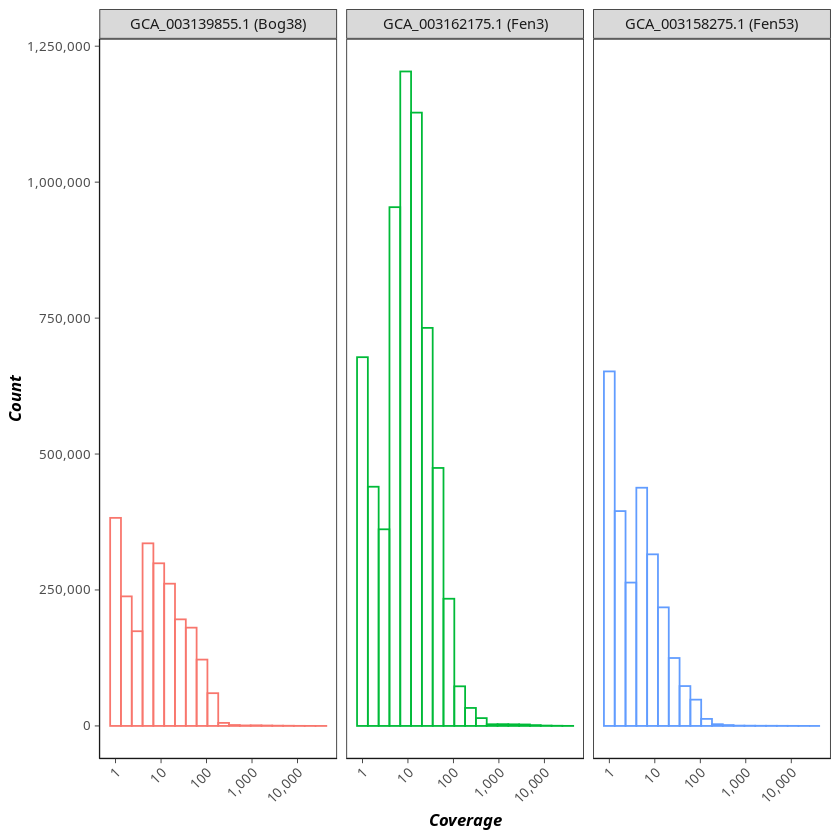

In [12]:
bog38_variant_depths <- fread("/home/n10853499/00-jupyter/02-lorikeet_testing/bog38_variant_depths.tsv")
bog38_variant_depths[, genome:="bog38"]
fen3_variant_depths <- fread("/home/n10853499/00-jupyter/02-lorikeet_testing/fen3_variant_depths.tsv")
fen3_variant_depths[, genome:="fen3"]
fen53_variant_depths <- fread("/home/n10853499/00-jupyter/02-lorikeet_testing/fen53_variant_depths.tsv")
fen53_variant_depths[, genome:="fen53"]

variant_depths <- rbind(bog38_variant_depths, fen3_variant_depths, fen53_variant_depths)

v_plot <- ggplot(variant_depths) +
    geom_histogram(aes(x=V1, color=genome), alpha=0.25, fill="white", position="identity", bins=20) +
    scale_x_log10(label=label_comma(accuracy=1)) +
    scale_y_continuous(label=comma) + 
    labs(x="Coverage", y="Count") +
    theme(
        plot.title=element_text(size=12, face="bold", hjust=0.5),
        axis.text=element_text(size=8),
        axis.title=element_text(size=10, face="bold.italic"),
        axis.title.y=element_text(margin = margin(t = 0, r=0, b = 0, l = 0)),
        # axis.title.x=element_blank(),
        axis.line = element_line(size=0.25),
        axis.ticks=element_line(size=0.25),
        strip.text.y=element_text(size=6),
        axis.text.x=element_text(angle=45, hjust=1, vjust=1),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        legend.position="none",
        legend.direction="horizontal", 
        legend.text=element_text(size=10), 
        legend.background=element_blank(), 
        legend.key=element_blank()) +
    facet_wrap(~genome, labeller=labeller(
        genome=as_labeller(
            c(
                `bog38`="GCA_003139855.1 (Bog38)",
                `fen3`="GCA_003162175.1 (Fen3)",
                `fen53`="GCA_003158275.1 (Fen53)"
            )
        )
    ))
v_plot

[1] 99.01925


Warning message:
“Heatmap/annotation names are duplicated: ANI”
No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
“Transformation introduced infinite values in continuous x-axis”
No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
“Transformation introduced infinite values in continuous x-axis”
No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



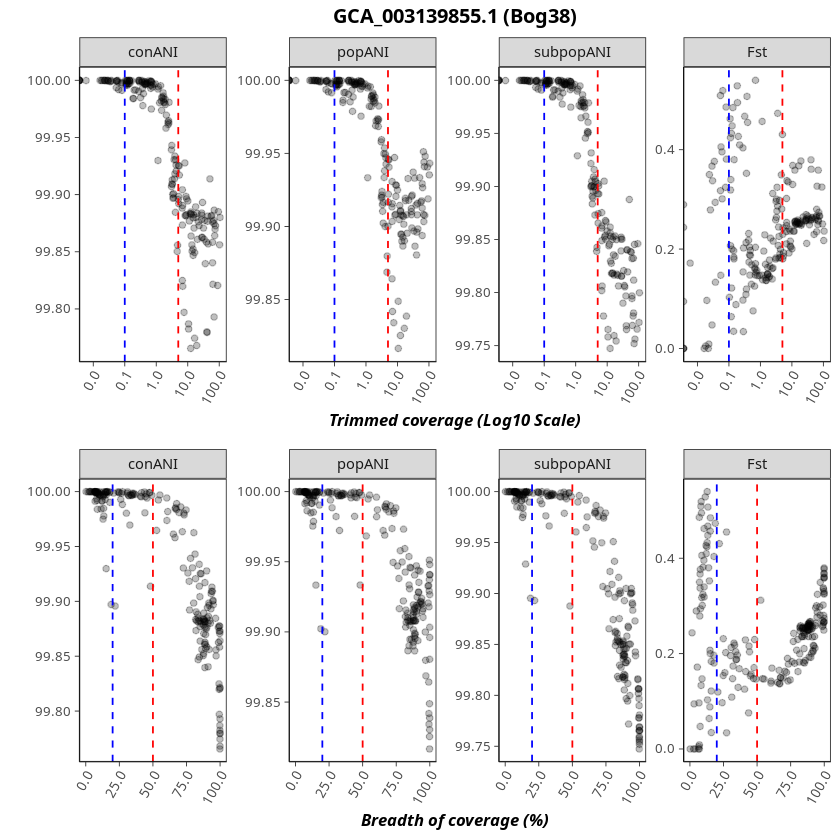

Warning message:
“Transformation introduced infinite values in continuous x-axis”


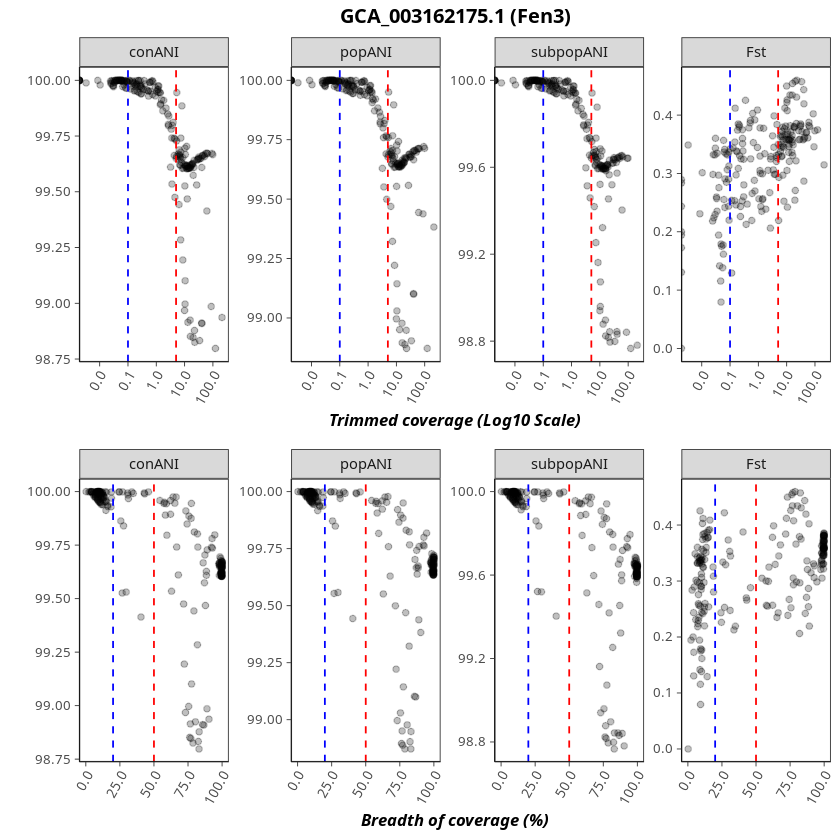

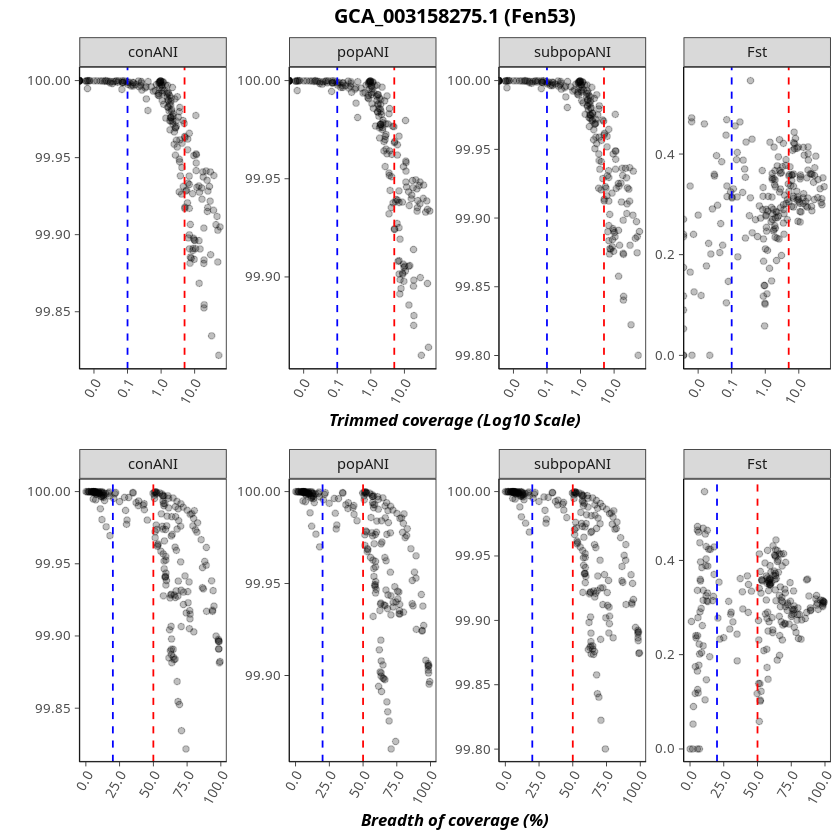

In [38]:
# ANI and Fst VS coverage and covered fraction
# ANI is entirely linked to coverage, Fst is more robust and returns meaningful results at both low coverage and low covered genome fractions
# bog38_metrics <- metric_vs_coverage(bog38)
bog38_list <- generate_heatmap(bog38)
# metric_vs_coverage(fen3)
# metric_vs_coverage(fen53)
# bog38_list[1]
# grid.grabExpr(bog38_list$fst)
bog38_left <- ggarrange(grid.grabExpr(draw(bog38_list$con, column_title="GCA_003139855.1 (Bog38)", column_title_gp = gpar(fontsize = 12, fontface = "bold", hjust=1), merge_legend=TRUE)), grid.grabExpr(draw(bog38_list$fst, merge_legend=TRUE)), ncol=1, labels=c("B)", "C)"))
bog38_right <- ggarrange(metric_vs_coverage(bog38), metric_vs_coverage(fen3, title="GCA_003162175.1 (Fen3)"), metric_vs_coverage(fen53, title="GCA_003158275.1 (Fen53)"), ncol=1, labels=c("D)", "E)", "F)"))
g <- arrangeGrob(bog38_left, bog38_right, ncol=2)
g <- ggarrange(v_plot, g, labels=c("A)", ""), nrow=2, heights=c(0.2, 0.8))
ggsave(file="/home/n10853499/00-jupyter/02-lorikeet_testing/ani_plots/bog38_ani_fst_with_metrics.png", height=18, width=15, g)
# bog38_left

In [39]:
bog38_list <- generate_heatmap(bog38)

# svg("/home/n10853499/00-jupyter/02-lorikeet_testing/ani_plots/bog38_ani_maps_top_0.7.2.svg",width=12,height=7)
# draw(bog38_list[[1]], merge_legend=T, column_title="GCA_003139855.1 ANI distributions (Bog38)", heatmap_legend_side = "right", annotation_legend_side = "bottom", ht_gap = unit(1.05, "cm"))
# dev.off()

# svg("/home/n10853499/00-jupyter/02-lorikeet_testing/ani_plots/bog38_ani_maps_bot_0.7.2.svg",width=12,height=7)
# draw(bog38_list[[2]], merge_legend=T, column_title="", heatmap_legend_side = "right", annotation_legend_side = "bottom", main_heatmap="Fst", ht_gap = unit(1, "cm"))
# dev.off()




bog38_hm <- ggarrange(
    grid.grabExpr(draw(bog38_list$con, merge_legend=TRUE)),
    grid.grabExpr(draw(bog38_list$pop, merge_legend=TRUE)),
    grid.grabExpr(draw(bog38_list$sub_pop, merge_legend=TRUE)), 
    grid.grabExpr(draw(bog38_list$fst, merge_legend=TRUE)), 
    ncol=2, nrow=2, labels=c("A)", "B)", "C)", "D)")
    )
# bog38_hm
ggsave(file="/home/n10853499/00-jupyter/02-lorikeet_testing/ani_plots/bog38_ani_fst.png", height=15, width=15, bog38_hm)



[1] 99.01925


Warning message:
“Heatmap/annotation names are duplicated: ANI”


In [40]:
fen3_list <- generate_heatmap(fen3)

# svg("/home/n10853499/00-jupyter/02-lorikeet_testing/ani_plots/fen3_ani_maps_top_0.7.2.svg",width=12,height=7)
# draw(fen3_list[[1]], merge_legend=T, column_title="GCA_003162175.1 ANI distributions (Fen3)", heatmap_legend_side = "right", annotation_legend_side = "bottom", ht_gap = unit(1.05, "cm"))
# dev.off()

# svg("/home/n10853499/00-jupyter/02-lorikeet_testing/ani_plots/fen3_ani_maps_bot_0.7.2.svg",width=12,height=7)
# draw(fen3_list[[2]], merge_legend=T, column_title="", heatmap_legend_side = "right", annotation_legend_side = "bottom", main_heatmap="Fst", ht_gap = unit(1, "cm"))
# dev.off()

fen3_hm <- ggarrange(
    grid.grabExpr(draw(fen3_list$con, merge_legend=TRUE)),
    grid.grabExpr(draw(fen3_list$pop, merge_legend=TRUE)),
    grid.grabExpr(draw(fen3_list$sub_pop, merge_legend=TRUE)), 
    grid.grabExpr(draw(fen3_list$fst, merge_legend=TRUE)), 
    ncol=2, nrow=2, labels=c("A)", "B)", "C)", "D)")
    )

ggsave(file="/home/n10853499/00-jupyter/02-lorikeet_testing/ani_plots/fen3_ani_fst.png", height=15, width=15, fen3_hm)

[1] 96.21523


Warning message:
“Heatmap/annotation names are duplicated: ANI”


In [41]:
fen53_list <- generate_heatmap(fen53)

# svg("/home/n10853499/00-jupyter/02-lorikeet_testing/ani_plots/fen53_ani_maps_top_0.7.2.svg",width=12,height=7)
# draw(fen53_list[[1]], merge_legend=T, column_title="GCA_003158275.1 ANI distributions (Fen53)", heatmap_legend_side = "right", annotation_legend_side = "bottom", ht_gap = unit(1.05, "cm"))
# dev.off()

# svg("/home/n10853499/00-jupyter/02-lorikeet_testing/ani_plots/fen53_ani_maps_bot_0.7.2.svg",width=12,height=7)
# draw(fen53_list[[2]], merge_legend=T, column_title="", heatmap_legend_side = "right", annotation_legend_side = "bottom", main_heatmap="Fst", ht_gap = unit(1, "cm"))
# dev.off()
fen53_hm <- ggarrange(
    grid.grabExpr(draw(fen53_list$con, merge_legend=TRUE)),
    grid.grabExpr(draw(fen53_list$pop, merge_legend=TRUE)),
    grid.grabExpr(draw(fen53_list$sub_pop, merge_legend=TRUE)), 
    grid.grabExpr(draw(fen53_list$fst, merge_legend=TRUE)), 
    ncol=2, nrow=2, labels=c("A)", "B)", "C)", "D)")
    )

# fen53_hm
ggsave(file="/home/n10853499/00-jupyter/02-lorikeet_testing/ani_plots/fen53_ani_fst.png", height=15, width=15, fen53_hm)

[1] 98.95797


Warning message:
“Heatmap/annotation names are duplicated: ANI”


In [12]:
fen53$con

SampleID,1,2,3,4,5,6,7,8,9,⋯,taxon_name,location,type,V1,Genome.x,value,Genome.y,fraction,sample_name_fixed,log10_abundance
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,-Inf,0.9999995,0.9999995,0.9999995,0.9999995,0.9999990,0.9999971,0.9999990,0.9999971,⋯,permafrost,Chersky,NA,1,GCA_003158275.1_20120600_E3D_genomic,0.139742270,GCA_003158275.1_20120600_E3D_genomic,0.117727550,Metagenome,-0.5910120
2,0.9999995,-Inf,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9999995,1.0000000,⋯,permafrost,Chersky,NA,2,GCA_003158275.1_20120600_E3D_genomic,0.020593030,GCA_003158275.1_20120600_E3D_genomic,0.068230145,Metagenome,-0.6023114
3,0.9999995,1.0000000,-Inf,1.0000000,1.0000000,0.9999995,0.9999995,0.9999995,0.9999995,⋯,permafrost,Chersky,NA,3,GCA_003158275.1_20120600_E3D_genomic,0.035381020,GCA_003158275.1_20120600_E3D_genomic,0.078035610,Metagenome,-0.6009090
4,0.9999995,1.0000000,1.0000000,-Inf,0.9999995,0.9999995,0.9999981,0.9999990,0.9999986,⋯,permafrost,Chersky,NA,4,GCA_003158275.1_20120600_E3D_genomic,0.030756300,GCA_003158275.1_20120600_E3D_genomic,0.077374820,Metagenome,-0.6013475
5,0.9999995,1.0000000,1.0000000,0.9999995,-Inf,1.0000000,0.9999976,0.9999995,0.9999981,⋯,permafrost,Chersky,NA,5,GCA_003158275.1_20120600_E3D_genomic,0.050397740,GCA_003158275.1_20120600_E3D_genomic,0.087878734,Metagenome,-0.5994849
6,0.9999990,1.0000000,0.9999995,0.9999995,1.0000000,-Inf,0.9999961,0.9999990,0.9999981,⋯,permafrost,Chersky,NA,6,GCA_003158275.1_20120600_E3D_genomic,0.072546005,GCA_003158275.1_20120600_E3D_genomic,0.097472040,Metagenome,-0.5973845
7,0.9999971,1.0000000,0.9999995,0.9999981,0.9999976,0.9999961,-Inf,0.9999971,0.9999990,⋯,permafrost,Chersky,NA,7,GCA_003158275.1_20120600_E3D_genomic,0.221180600,GCA_003158275.1_20120600_E3D_genomic,0.131727520,Metagenome,-0.5832889
8,0.9999990,0.9999995,0.9999995,0.9999990,0.9999995,0.9999990,0.9999971,-Inf,0.9999966,⋯,permafrost,Chersky,NA,8,GCA_003158275.1_20120600_E3D_genomic,0.071183350,GCA_003158275.1_20120600_E3D_genomic,0.097944980,Metagenome,-0.5975137
9,0.9999971,1.0000000,0.9999995,0.9999986,0.9999981,0.9999981,0.9999990,0.9999966,-Inf,⋯,permafrost,Chersky,NA,9,GCA_003158275.1_20120600_E3D_genomic,0.071902440,GCA_003158275.1_20120600_E3D_genomic,0.098284915,Metagenome,-0.5974455


Warning message in melt.data.table(mflorens_coverage):
“To be consistent with reshape2's melt, id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [Genome]. Consider providing at least one of 'id' or 'measure' vars in future.”

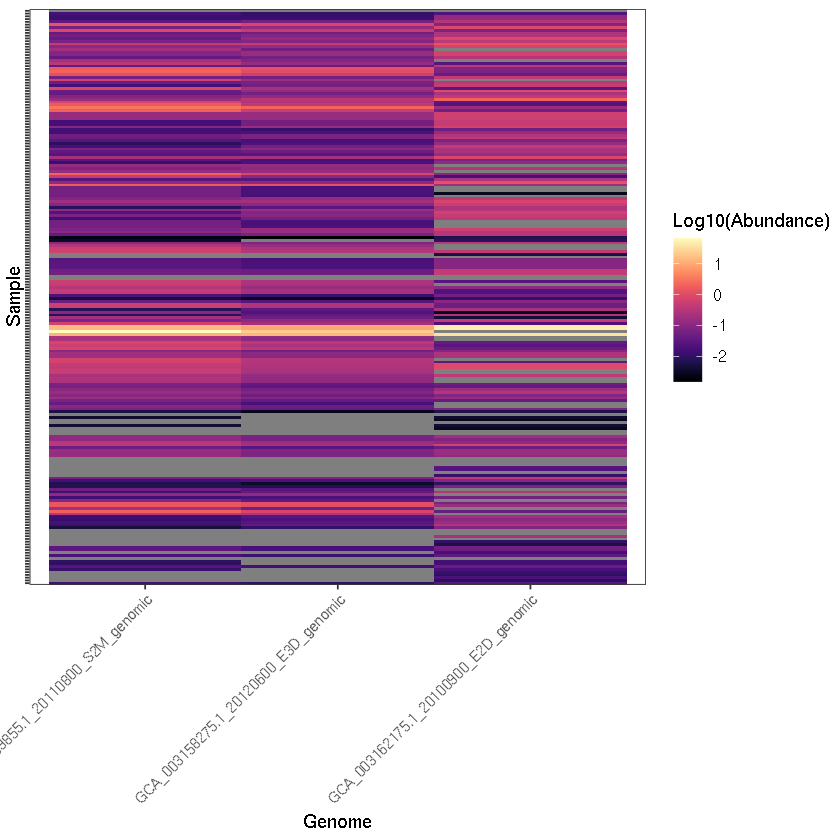

In [40]:
# melt(mflorens_coverage)
mflorens_coverage_m <- melt(mflorens_coverage)
mflorens_coverage_m[, value:=ifelse(is.nan(value), 0.0, value)]
ggplot(data=mflorens_coverage_m[Genome != 'unmapped' & is.finite(value)], aes(x=Genome, fill=log10(value), y=variable)) +
    geom_tile() +
#     scale_fill_viridis(discrete = TRUE, alpha=0.6) +
    labs(fill="Log10(Abundance)", x = "Genome", y = "Sample") + 
    scale_fill_viridis(option="magma") + 
#     geom_text(aes(y=assembly_size + 3500000, x=assembler, label=max_contig_size), size=2) + 
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          legend.position="right",
          legend.direction="vertical", 
          legend.text=element_text(size=10),
          axis.text.x=element_text(angle=45, hjust=1, vjust=1),
          axis.text.y=element_blank()
         )

In [38]:
mflorens_coverage_m[is.finite(value)]

Genome,variable,value
unmapped,SRR10489811_1.fastq.gz Relative Abundance (%),99.947700000
GCA_003139855.1_20110800_S2M_genomic,SRR10489811_1.fastq.gz Relative Abundance (%),0.015584408
GCA_003158275.1_20120600_E3D_genomic,SRR10489811_1.fastq.gz Relative Abundance (%),0.010211179
GCA_003162175.1_20100900_E2D_genomic,SRR10489811_1.fastq.gz Relative Abundance (%),0.026500340
unmapped,SRR10489814_1.fastq.gz Relative Abundance (%),99.991486000
GCA_003139855.1_20110800_S2M_genomic,SRR10489814_1.fastq.gz Relative Abundance (%),0.000000000
GCA_003158275.1_20120600_E3D_genomic,SRR10489814_1.fastq.gz Relative Abundance (%),0.000000000
GCA_003162175.1_20100900_E2D_genomic,SRR10489814_1.fastq.gz Relative Abundance (%),0.008514292
unmapped,SRR10489815_1.fastq.gz Relative Abundance (%),99.980180000
GCA_003139855.1_20110800_S2M_genomic,SRR10489815_1.fastq.gz Relative Abundance (%),0.000000000


In [5]:
mflorens$pop

SampleID,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
1,0.9991909,0.9999845,0.9999388,0.9999947,0.9999709,0.9999633,0.9999679,0.9999672,0.9999735,...,0.9996487,0.9998342,0.9993200,0.9997298,0.9993052,0.9997548,0.9999022,0.9999118,0.9998696,0.9999667
2,0.9999845,0.9995722,0.9999874,0.9999900,0.9999801,0.9999699,0.9999822,0.9999803,0.9999789,...,0.9998058,0.9998827,0.9996535,0.9998631,0.9996388,0.9998482,0.9999454,0.9999255,0.9999225,0.9999735
3,0.9999388,0.9999874,0.9993420,0.9999631,0.9999772,0.9999366,0.9999521,0.9999488,0.9999517,...,0.9996618,0.9998346,0.9994312,0.9997642,0.9994190,0.9997662,0.9999136,0.9999132,0.9998839,0.9999658
4,0.9999947,0.9999900,0.9999631,0.9996744,0.9999903,0.9999854,0.9999904,0.9999937,0.9999879,...,0.9998599,0.9999442,0.9997277,0.9998906,0.9997118,0.9999000,0.9999490,0.9999667,0.9999305,0.9999876
5,0.9999709,0.9999801,0.9999772,0.9999903,0.9994758,0.9999791,0.9999900,0.9999815,0.9999825,...,0.9997692,0.9998754,0.9995558,0.9998233,0.9995445,0.9998384,0.9999213,0.9999334,0.9999099,0.9999757
6,0.9999633,0.9999699,0.9999366,0.9999854,0.9999791,0.9994605,0.9999696,0.9999815,0.9999752,...,0.9997844,0.9998983,0.9995496,0.9998473,0.9995390,0.9998781,0.9999361,0.9999570,0.9998893,0.9999859
7,0.9999679,0.9999822,0.9999521,0.9999904,0.9999900,0.9999696,0.9990331,0.9999879,0.9999849,...,0.9995913,0.9997963,0.9991781,0.9996995,0.9991588,0.9997426,0.9998733,0.9999004,0.9998278,0.9999646
8,0.9999672,0.9999803,0.9999488,0.9999937,0.9999815,0.9999815,0.9999879,0.9994355,0.9999849,...,0.9997584,0.9998771,0.9995412,0.9998321,0.9995141,0.9998417,0.9999196,0.9999335,0.9999063,0.9999750
9,0.9999735,0.9999789,0.9999517,0.9999879,0.9999825,0.9999752,0.9999849,0.9999849,0.9994675,...,0.9997666,0.9998711,0.9995506,0.9998105,0.9995332,0.9998414,0.9999245,0.9999461,0.9999068,0.9999765
10,0.9999743,0.9999791,0.9999682,0.9999920,0.9999913,0.9999883,0.9999864,0.9999905,0.9999917,...,0.9999111,0.9999529,0.9998504,0.9999388,0.9998432,0.9999386,0.9999689,0.9999709,0.9999493,0.9999910



Setting initial dates...
Fitting in progress... get a first set of estimates
         (Penalised) log-lik = -264060.4 
Optimising rates... dates... -264060.4 
Optimising rates... dates... -232.6845 
Optimising rates... dates... -231.1 
Optimising rates... dates... -227.9952 
Optimising rates... dates... -226.2269 
Optimising rates... dates... -224.9493 
Optimising rates... dates... -223.208 
Optimising rates... dates... -221.037 
Optimising rates... dates... -218.4519 
Optimising rates... dates... -216.475 
Optimising rates... dates... -215.2727 
Optimising rates... dates... -214.1979 
Optimising rates... dates... -213.4444 
Optimising rates... dates... -212.7499 
Optimising rates... dates... -212.0979 
Optimising rates... dates... -211.4907 
Optimising rates... dates... -210.7608 
Optimising rates... dates... -210.1597 
Optimising rates... dates... -209.2974 
Optimising rates... dates... -208.6322 


Warning message:
“Maximum number of dual iterations reached.”Warning message:
“function evaluation limit reached without convergence (9)”


log-Lik = -192.7292 
PHIIC = 1628.55 

Setting initial dates...
Fitting in progress... get a first set of estimates
         (Penalised) log-lik = -6898684 
Optimising rates... dates... -6898684 
Optimising rates... dates... -332.0741 
Optimising rates... dates... -234.6194 
Optimising rates... dates... -228.1689 
Optimising rates... dates... -223.0339 
Optimising rates... dates... -217.8242 
Optimising rates... dates... -212.0238 
Optimising rates... dates... -207.5863 
Optimising rates... dates... -203.3181 
Optimising rates... dates... -200.5474 
Optimising rates... dates... -196.514 
Optimising rates... dates... -193.3244 
Optimising rates... dates... -191.7983 
Optimising rates... dates... -189.6598 
Optimising rates... dates... -188.1633 
Optimising rates... dates... -186.4681 
Optimising rates... dates... -185.2226 
Optimising rates... dates... -183.8568 
Optimising rates... dates... -182.9339 
Optimising rates... dates... -181.7858 


Warning message:
“Maximum number of dual iterations reached.”Warning message:
“function evaluation limit reached without convergence (9)”


log-Lik = -173.9178 
PHIIC = 1589.1 


[1] TRUE

[1] TRUE

[1] TRUE

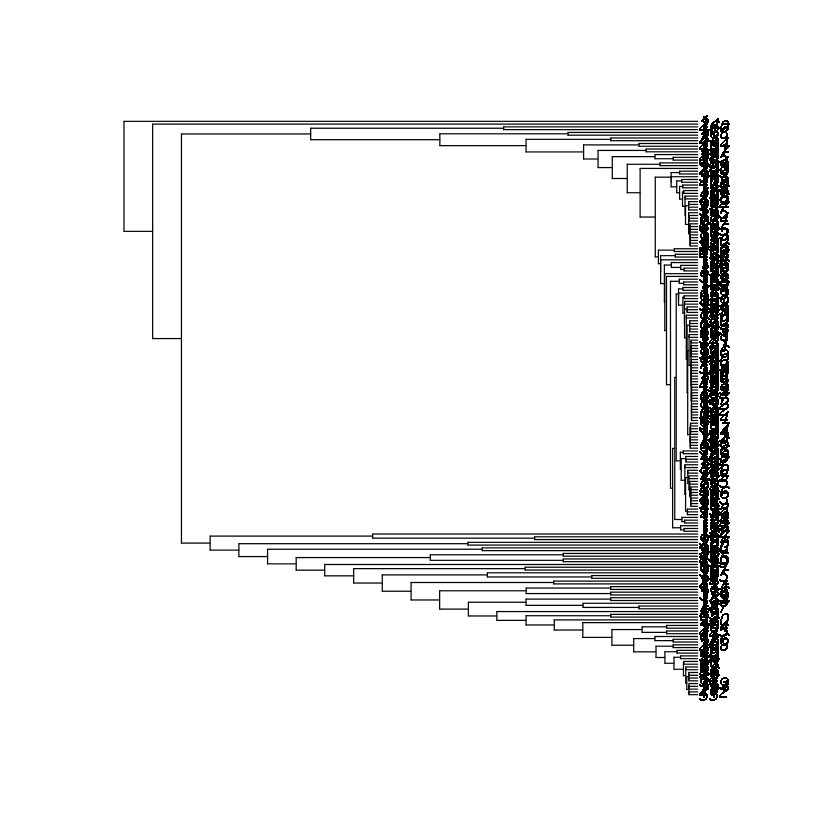

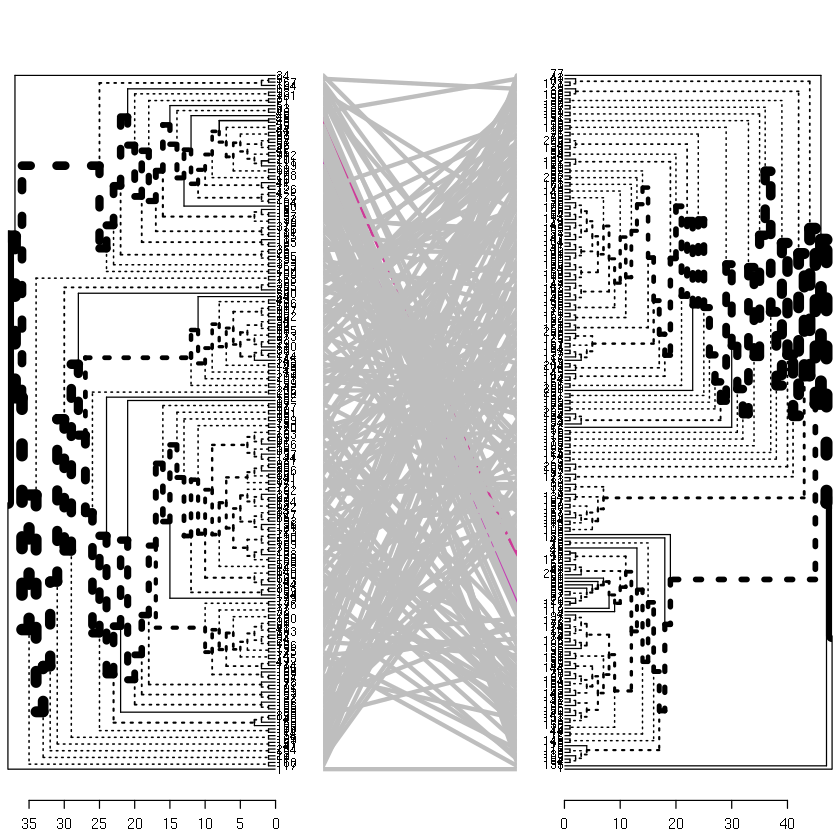

In [87]:

## build neighbor joining trees
mflorens_con <- mflorens$pop
fen1_con <- fen1$pop
mflorens_phy <- nj(as.matrix(mflorens_con[, -1, with=FALSE]))
fen1_phy <- nj(as.matrix(fen1_con[, -1, with=FALSE]))

## set the root sample
mflorens_phy <- root(mflorens_phy, 1, resolve.root=TRUE)
fen1_phy <- root(fen1_phy, 1, resolve.root=TRUE)
# mflorens_phy$root.edge <- 6
# fen1_phy$root.edge <- 6

mflorens_phy <- chronos(mflorens_phy)
fen1_phy <- chronos(fen1_phy)
is.ultrametric(mflorens_phy)
is.rooted(mflorens_phy)
is.binary(mflorens_phy)
# plot(mflorens_phy)

# convert to dendrograms
mflorens_dnd <- as.dendrogram(mflorens_phy)
fen1_dnd <- as.dendrogram(fen1_phy)

# rearrange in ladderized fashion
mflorens_dnd <- ladder(mflorens_dnd)
fen1_dnd <- ladder(fen1_dnd)

# plot tanglegram
dndlist <- dendlist(mflorens_dnd, fen1_dnd)


[1] 0.2608555

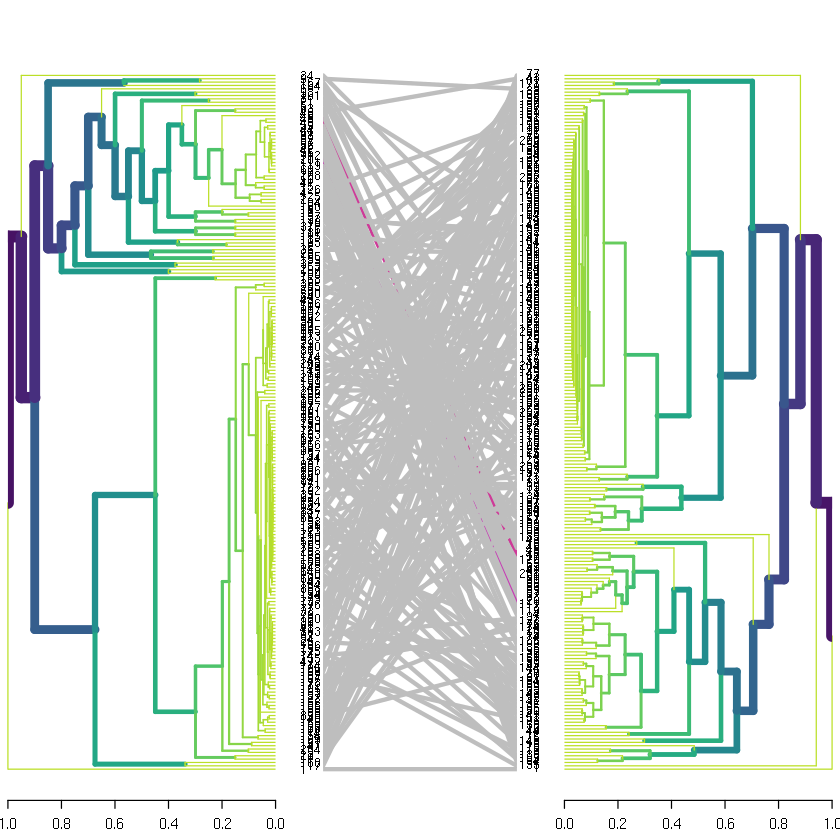

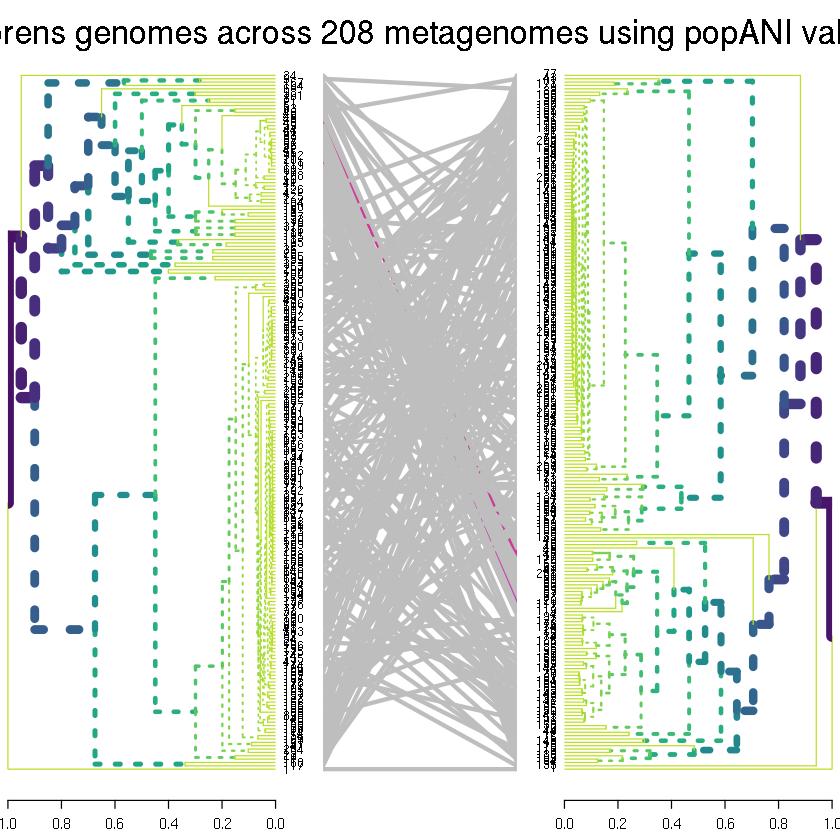

In [113]:
# dndlist <- dendlist(highlight_branches(mflorens_dnd), highlight_branches(fen1_dnd))
# dndlist <- untangle(dndlist, method="step2side")
entanglement(dndlist)

tanglegram(
    dndlist, 
    sort=TRUE, rank_branches=FALSE, margin_inner=3, 
    lab.cex=0.9, dLeaf=-0.1, common_subtrees_color_lines = TRUE,
    highlight_distinct_edges = FALSE, highlight_branches_lwd = FALSE
    ) %>% 
        plot(main = paste0("Tanglegram of two Candidatus methanoflorens genomes across 208 metagenomes using popANI values: Entanglement = ", entanglement(dndlist)))

[1] 0

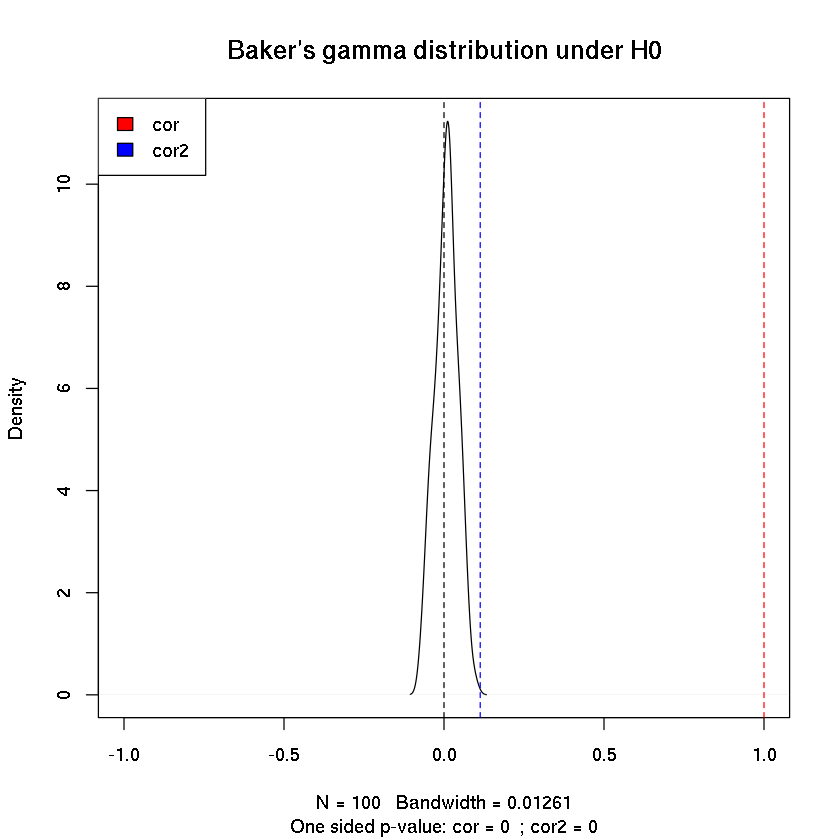

In [108]:
R <- 100
# cor_bakers_gamma_results <- numeric(R)
# dend_mixed <- mflorens_dnd
# for(i in 1:R) {
#    dend_mixed <- sample.dendrogram(dend_mixed, replace = FALSE)
#    cor_bakers_gamma_results[i] <- cor_bakers_gamma(mflorens_dnd, dend_mixed)
# }
plot(density(cor_bakers_gamma_results),
     main = "Baker's gamma distribution under H0",
     xlim = c(-1,1))
abline(v = 0, lty = 2)
abline(v = cor_bakers_gamma(mflorens_dnd, mflorens_dnd), lty = 2, col = 2)
abline(v = cor_bakers_gamma(dndlist), lty = 2, col = 4)
legend("topleft", legend = c("cor", "cor2"), fill = c(2,4))
round(sum(cor_bakers_gamma(dndlist) < cor_bakers_gamma_results)/ R, 4)
title(sub = paste("One sided p-value:",
                  "cor =",  round(sum(cor_bakers_gamma(mflorens_dnd, mflorens_dnd) < cor_bakers_gamma_results)/ R, 4),
                  " ; cor2 =",  round(sum(cor_bakers_gamma(dndlist) < cor_bakers_gamma_results)/ R, 4)
                  ))

ERROR: Error in title(sub = paste("One sided p-value:", "cor =", round(sum(cor_bakers_gamma(mflorens_dnd, : plot.new has not been called yet


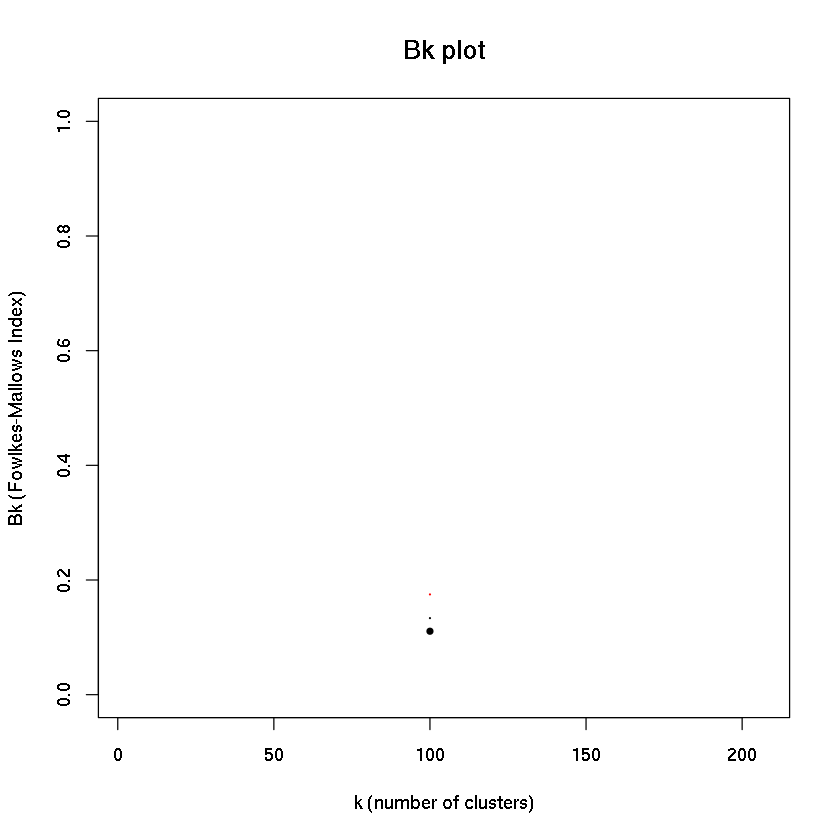

In [112]:
Bk_plot(mflorens_dnd, fen1_dnd, k=100)

Warning message in melt.data.table(mflorens_coverage):
“To be consistent with reshape2's melt, id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [Genome]. Consider providing at least one of 'id' or 'measure' vars in future.”Warning message:
“Removed 111 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 111 rows containing missing values (geom_point).”

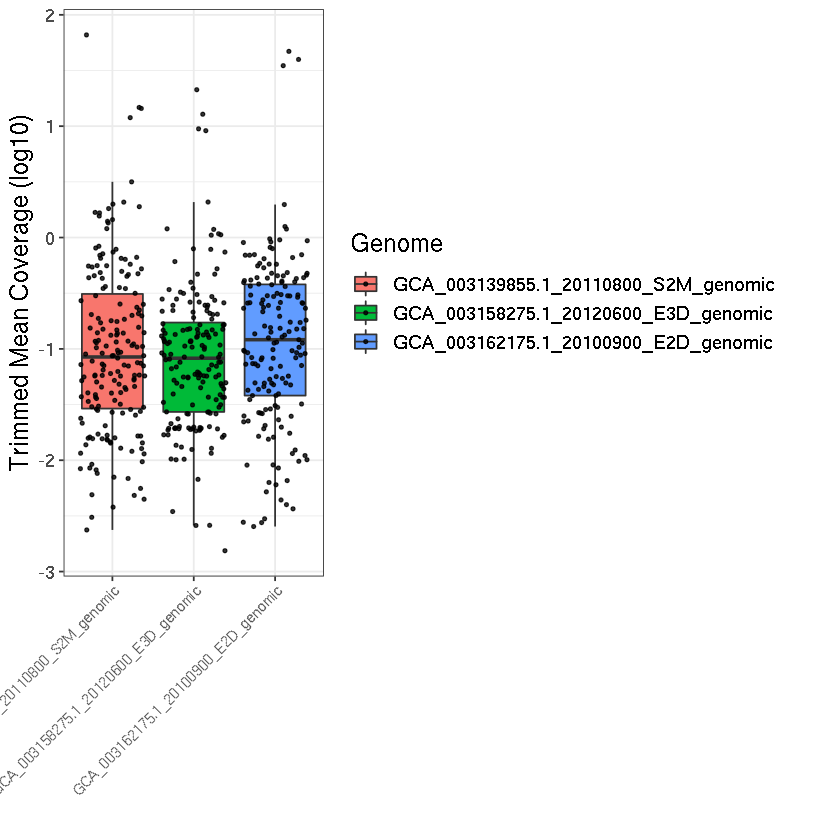

In [316]:
melt(mflorens_coverage)[66:93,]

Warning message in melt.data.table(mflorens_coverage):
“To be consistent with reshape2's melt, id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [Genome]. Consider providing at least one of 'id' or 'measure' vars in future.”

Genome,variable,value
GCA_003139855.1_20110800_S2M_genomic,SRR10489839_1.fastq.gz Relative Abundance (%),NaN
GCA_003158275.1_20120600_E3D_genomic,SRR10489839_1.fastq.gz Relative Abundance (%),NaN
GCA_003162175.1_20100900_E2D_genomic,SRR10489839_1.fastq.gz Relative Abundance (%),NaN
unmapped,SRR10907119_1.fastq.gz Relative Abundance (%),9.978430e+01
GCA_003139855.1_20110800_S2M_genomic,SRR10907119_1.fastq.gz Relative Abundance (%),0.000000e+00
GCA_003158275.1_20120600_E3D_genomic,SRR10907119_1.fastq.gz Relative Abundance (%),0.000000e+00
GCA_003162175.1_20100900_E2D_genomic,SRR10907119_1.fastq.gz Relative Abundance (%),2.156954e-01
unmapped,SRR10907120_1.fastq.gz Relative Abundance (%),1.000000e+02
GCA_003139855.1_20110800_S2M_genomic,SRR10907120_1.fastq.gz Relative Abundance (%),NaN
GCA_003158275.1_20120600_E3D_genomic,SRR10907120_1.fastq.gz Relative Abundance (%),NaN


In [209]:
92 -66
full_metadata[V1 >= 66 & V1 <= 92 & !is.na(taxon_name), ]

[1] 26

run,study_accession,Gbp,library_strategy,library_selection,model,sample_name,taxon_name,V1
SRR5440535,SRP103729,6.512,WGS,RANDOM,Illumina HiSeq 2000,MG_Fen1_75cm,peat metagenome,66
SRR6960558,SRP138675,59.491,WGS,RANDOM,Illumina HiSeq 2500,BPONN,permafrost metagenome,67
SRR6962291,SRP138804,59.071,WGS,RANDOM,Illumina HiSeq 2500,BPONP,permafrost metagenome,68
SRR7151493,SRP145414,12.405,WGS,RANDOM,Illumina HiSeq 2000,20120700_S1D..1,peat metagenome,69
SRR7151534,SRP145414,12.087,WGS,RANDOM,Illumina HiSeq 2000,20120700_S1D..5,peat metagenome,70
SRR7151536,SRP145414,4.478,WGS,RANDOM,Illumina HiSeq 2500,20120700_S1X.20140516.NA,peat metagenome,71
SRR7151563,SRP145414,4.822,WGS,RANDOM,NextSeq 500,20110700_S2M.20140916.NA,peat metagenome,72
SRR7151564,SRP145414,6.661,WGS,RANDOM,NextSeq 500,20110700_S2D.20140916.NA,peat metagenome,73
SRR7151575,SRP145414,5.985,WGS,RANDOM,Illumina HiSeq 2000,20120700_S3X.20140723.NA,peat metagenome,74
SRR7151576,SRP145414,8.006,WGS,RANDOM,Illumina HiSeq 2000,20120800_E1D.20140723.NA,peat metagenome,75


In [288]:
full_metadata[V1 >= 0 & V1 <= 66 & !is.na(taxon_name), ]

run,study_accession,Gbp,library_strategy,library_selection,model,sample_name,taxon_name,V1,SampleID
SRR10489821,SRP229959,14.861,WGS,RANDOM,Illumina HiSeq 4000,Metagenome,permafrost metagenome,1,1
SRR10907119,SRP242528,6.283,WGS,RANDOM,Illumina NovaSeq 6000,1-17_5.4_m_B,permafrost metagenome,2,2
SRR10907120,SRP242528,4.697,WGS,RANDOM,Illumina NovaSeq 6000,1-17_5.4_m_A,permafrost metagenome,3,3
SRR12951261,SRP290047,32.237,WGS,RANDOM,Illumina NovaSeq 6000,GWBAP,peat metagenome,12,12
SRR12951262,SRP290048,25.369,WGS,RANDOM,Illumina NovaSeq 6000,GWBAO,peat metagenome,13,13
SRR12951263,SRP290049,57.143,WGS,RANDOM,Illumina NovaSeq 6000,GUYWW,peat metagenome,14,14
SRR12951266,SRP290051,31.483,WGS,RANDOM,Illumina NovaSeq 6000,GWBAU,peat metagenome,15,15
SRR12951267,SRP290052,65.661,WGS,RANDOM,Illumina NovaSeq 6000,GUYWU,peat metagenome,16,16
SRR12951269,SRP290054,27.378,WGS,RANDOM,Illumina NovaSeq 6000,GWBBC,peat metagenome,17,17
SRR12951270,SRP290055,38.937,WGS,RANDOM,Illumina NovaSeq 6000,GWBAS,peat metagenome,18,18


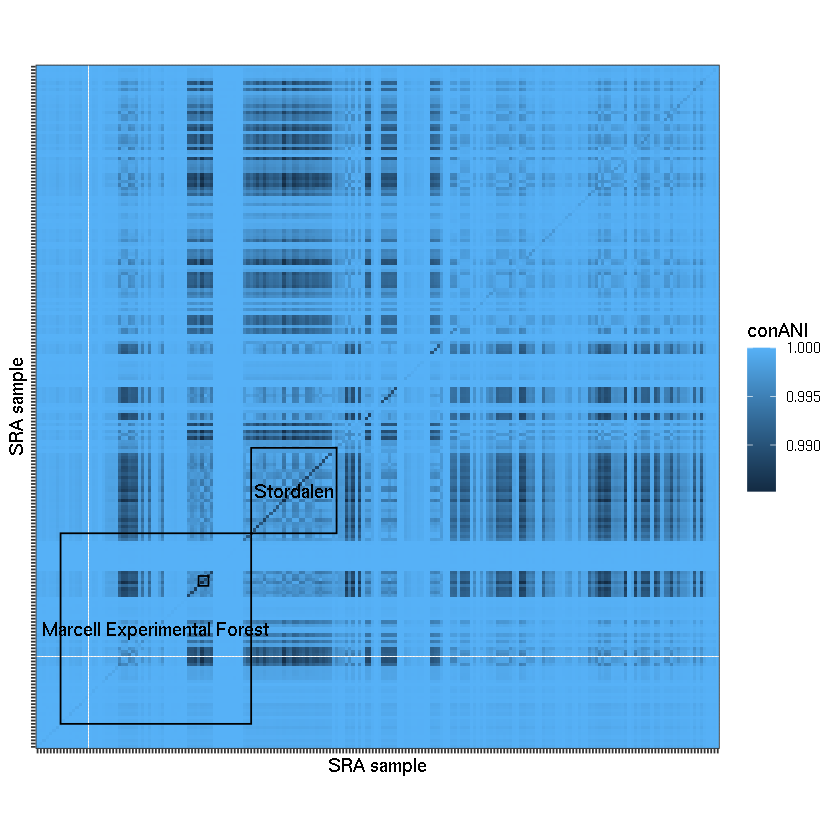

In [128]:

con_ani_melt <- melt((as.matrix((con_ani[,-1,with=FALSE]))))
# con_ani_melt$Var1 <- factor(con_ani_melt$Var1)
ggplot(data=con_ani_melt, aes(x=factor(Var1), y=factor(Var2), fill=value)) +
    geom_tile() +
    scale_fill_gradient(name="conANI") +
    theme(
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
    ) +
    annotate("rect", ymin=66, xmin=66, ymax=92, xmax=92, alpha=1, linetype=1, color="black", fill=NA) +
    annotate("text", y=79, x=79, alpha=1, color="black", label="Stordalen") +
    annotate("rect", ymin=8, xmin=8, ymax=66, xmax=66, alpha=1, linetype=1, color="black", fill=NA) + 
    annotate("text", y=37, x=37, alpha=1, color="black", label="Marcell Experimental Forest") +
    annotate("rect", ymin=50, xmin=50, ymax=53, xmax=53, alpha=1, linetype=1, color="black", fill=NA) + 
#     annotate("text", y=51.5, x=51,5, alpha=1, color="black", label="") +
    ylab("SRA sample") +
    xlab("SRA sample") +
    coord_fixed()

Warning message in `[.data.table`(joined_con_ani, , `:=`(sample_name_fixed, ifelse(is.na(sample_name), :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”Warning message

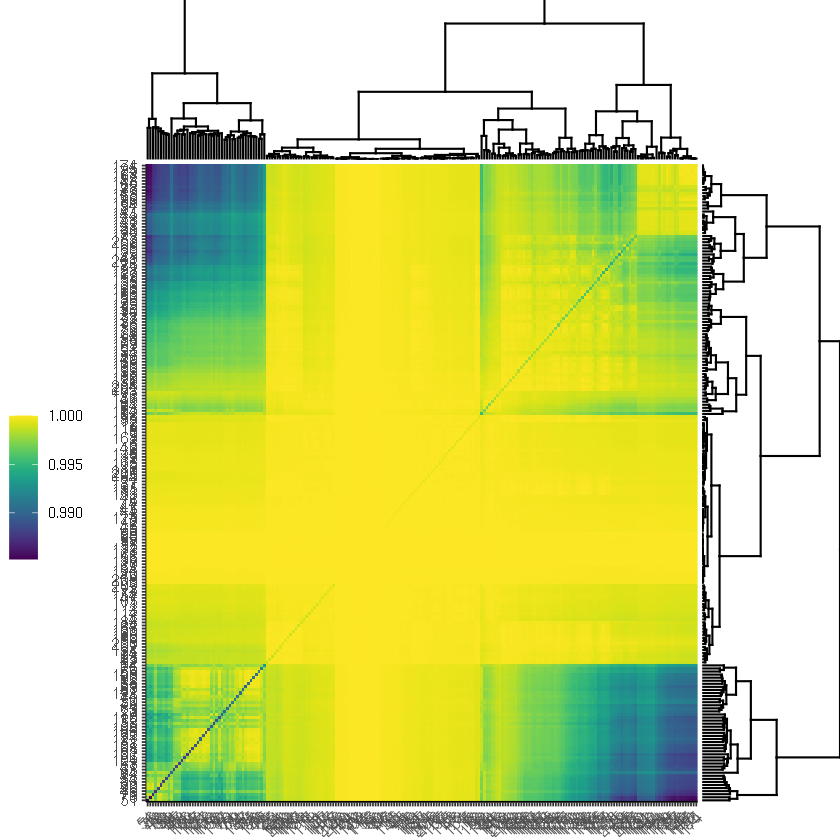

In [5]:
# sample_labels
con_ani[, SampleID:=factor(SampleID)]
joined_con_ani <- full_join(con_ani, full_metadata, by=c("SampleID"))
joined_con_ani[, sample_name_fixed := ifelse(is.na(sample_name), V1, sample_name)]
# joined_con_ani$sample_name_fixed
tmp <-ggheatmap(con_ani[, -1, with=FALSE],
                scale="none",
#                   xlab = "Sample Name",
#                   ylab = "Sample Name",
#                   labRow = joined_con_ani[!is.na(V1)]$sample_name_fixed,
#                   labCol = joined_con_ani[!is.na(V1)]$sample_name_fixed,
#                   file = "mflorens_con_ani_heatmap.html",
                  k_row = 1, k_col = 1)

In [ ]:
tmp

In [254]:
# ?heatmaply
# full_metadata[, SampleID:=V1]
# con_ani[, SampleID := factor(SampleID)]
nrow(joined_con_ani)
joined_con_ani$sample_name_fixed
con_mat <- matrix(con_ani[, -1, with=FALSE])
rownames(con_mat) <- joined_con_ani$sample_name_fixed
con_mat

[1] 96

[1] "Metagenome"                   "1-17_5.4_m_B"                
 [3] "1-17_5.4_m_A"                 "4"                           
 [5] "5"                            "6"                           
 [7] "7"                            "8"                           
 [9] "9"                            "10"                          
[11] "11"                           "GWBAP"                       
[13] "GWBAO"                        "GUYWW"                       
[15] "GWBAU"                        "GUYWU"                       
[17] "GWBBC"                        "GWBAS"                       
[19] "GWBAX"                        "GWSHH"                       
[21] "GWBAY"                        "GWUHW"                       
[23] "GWUHY"                        "GWBAW"                       
[25] "GWBAT"                        "GWBAZ"                       
[27] "GWBBA"                        "GWBBB"                       
[29] "GWBBG"                        "GWBBH"                       
[31] "GWCBH"                        "GWCBH"                       
[33] "GUYWX"                        "GWCBO"                       
[35] "GWCBO"                        "GWCBP"                       
[37] "GWCBP"                        "GWCBT"                       
[39] "GWCBT"                        "GWCBU"                       
[41] "GWCBU"                        "GWUHU"                       
[43] "GWUHX"                        "GWUHZ"                       
[45] "GWUNA"                        "GWCBC"                       
[47] "GWCBC"                        "GXBYW"                       
[49] "GXAZC"                        "241"                         
[51] "245"                          "222"                         
[53] "201"                          "GXYWW"                       
[55] "GUZYC"                        "2a"                          
[57] "3a"                           "GXYWT"                       
[59] "GUZYA"                        "GXXAB"                       
[61] "GXXAG"                        "GXXAN"                       
[63] "MG_T3M_75cm"                  "MG_T3M_30cm"                 
[65] "MG_T3F_30cm"                  "MG_Fen1_75cm"                
[67] "BPONN"                        "BPONP"                       
[69] "20120700_S1D..1"              "20120700_S1D..5"             
[71] "20120700_S1X.20140516.NA"     "20110700_S2M.20140916.NA"    
[73] "20110700_S2D.20140916.NA"     "20120700_S3X.20140723.NA"    
[75] "20120800_E1D.20140723.NA"     "20120700_S3D.20140723.NA"    
[77] "20110800_E2M..NA"             "20110800_E1D..NA"            
[79] "20120600_E2D.20140929.NA"     "20120600_E2D.20140923.NA"    
[81] "20110800_S1M.20130213.NA"     "20110800_S1D..NA"            
[83] "20110800_S2D..NA"             "20120800_S1D.20140516.NA"    
[85] "20100900_E1D.20100901.raw.NA" "20120800_S1X.20140516.NA"    
[87] "20110800_S2M..NA"             "20110800_S3D..NA"            
[89] "20120800_S2X.20140516.NA"     "20120700_S2X.20140516.NA"    
[91] "20120600_S2D.20140516.NA"     "20120600_E3D.20140923.NA"    
[93] "20110600_E3M.20140910.NA"     "20110600_S3M.20140903.NA"    
[95] "20110600_S2D.20140903.NA"     "20110800_S1M.20140903.NA"

ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [1] not equal to array extent


In [255]:
joined_con_ani

SampleID,1,2,3,4,5,6,7,8,9,...,run,study_accession,Gbp,library_strategy,library_selection,model,sample_name,taxon_name,V1,sample_name_fixed
1,0.9985674,0.9999985,0.9999985,0.9999801,0.9999514,0.9999573,0.9999811,0.9999714,0.9999898,...,SRR10489821,SRP229959,14.861,WGS,RANDOM,Illumina HiSeq 4000,Metagenome,permafrost metagenome,1,Metagenome
2,0.9999985,0.9999966,1.0000000,0.9999990,0.9999966,0.9999976,0.9999976,0.9999976,1.0000000,...,SRR10907119,SRP242528,6.283,WGS,RANDOM,Illumina NovaSeq 6000,1-17_5.4_m_B,permafrost metagenome,2,1-17_5.4_m_B
3,0.9999985,1.0000000,0.9999995,1.0000000,0.9999995,0.9999995,0.9999995,0.9999995,1.0000000,...,SRR10907120,SRP242528,4.697,WGS,RANDOM,Illumina NovaSeq 6000,1-17_5.4_m_A,permafrost metagenome,3,1-17_5.4_m_A
4,0.9999801,0.9999990,1.0000000,0.9993177,0.9993789,0.9995416,0.9997635,0.9996562,0.9999339,...,SRR11558355,NA,NA,NA,NA,NA,NA,NA,4,4
5,0.9999514,0.9999966,0.9999995,0.9993789,0.9999791,0.9999505,0.9993425,0.9996800,0.9997781,...,SRR11558358,NA,NA,NA,NA,NA,NA,NA,5,5
6,0.9999573,0.9999976,0.9999995,0.9995416,0.9999505,0.9999558,0.9994255,0.9997300,0.9998019,...,SRR11558359,NA,NA,NA,NA,NA,NA,NA,6,6
7,0.9999811,0.9999976,0.9999995,0.9997635,0.9993425,0.9994255,0.9993327,0.9995697,0.9998805,...,SRR11593346,NA,NA,NA,NA,NA,NA,NA,7,7
8,0.9999714,0.9999976,0.9999995,0.9996562,0.9996800,0.9997300,0.9995697,0.9996688,0.9998349,...,SRR11593348,NA,NA,NA,NA,NA,NA,NA,8,8
9,0.9999898,1.0000000,1.0000000,0.9999339,0.9997781,0.9998019,0.9998805,0.9998349,0.9997766,...,SRR11826759,NA,NA,NA,NA,NA,NA,NA,9,9
10,0.9999951,0.9999981,0.9999995,0.9999645,0.9997601,0.9997810,0.9998757,0.9998121,0.9999675,...,SRR12137140,NA,NA,NA,NA,NA,NA,NA,10,10


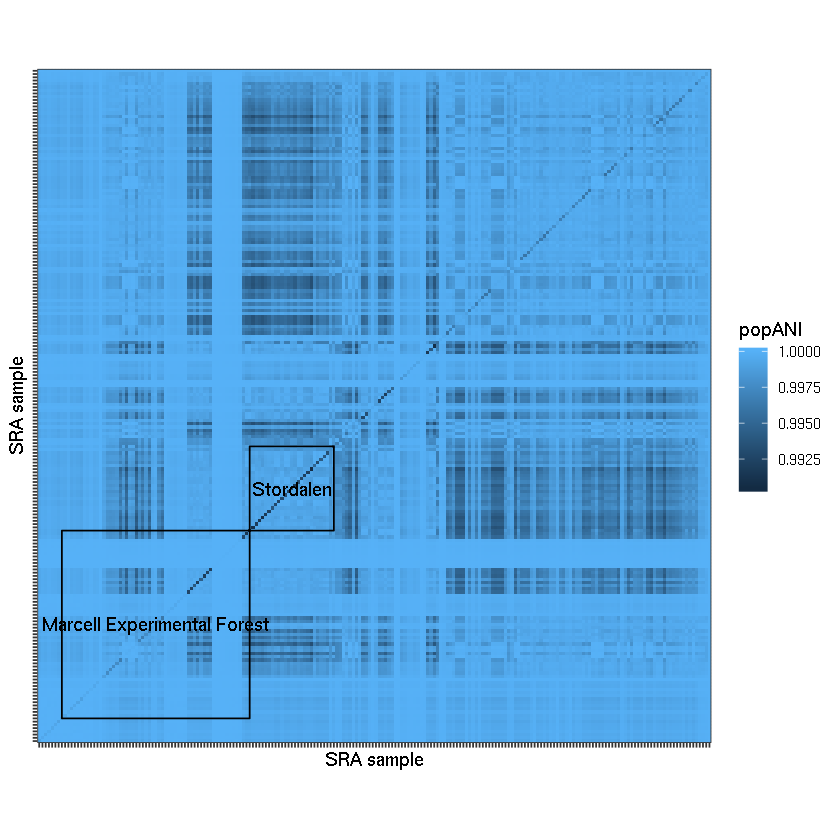

In [319]:
pop_ani_melt <- melt(as.matrix((pop_ani[,-1,with=FALSE])))
# con_ani_melt$Var1 <- factor(con_ani_melt$Var1)
ggplot(data=pop_ani_melt, aes(x=factor(Var1), y=factor(Var2), fill=value)) +
    geom_tile() +
    scale_fill_gradient(name="popANI") +
    theme(
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
    ) +
    annotate("rect", ymin=66, xmin=66, ymax=92, xmax=92, alpha=1, linetype=1, color="black", fill=NA) +
    annotate("text", y=79, x=79, alpha=1, color="black", label="Stordalen") +
    annotate("rect", ymin=8, xmin=8, ymax=66, xmax=66, alpha=1, linetype=1, color="black", fill=NA) + 
    annotate("text", y=37, x=37, alpha=1, color="black", label="Marcell Experimental Forest") +
    ylab("SRA sample") +
    xlab("SRA sample") +
    coord_fixed()

In [320]:
tmp <-heatmaply(pop_ani[, -1, with=FALSE],
                  xlab = "Sample Name",
                  ylab = "Sample Name",
                  labRow = joined_con_ani[!is.na(V1)]$sample_name_fixed,
                  labCol = joined_con_ani[!is.na(V1)]$sample_name_fixed,
                  file = "/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/pop_ani_heatmap.html",
                  k_row = 1, k_col = 1, plot_method="ggplot")

Warning message in fix_not_all_unique(rownames(x)):
“Not all the values are unique - manually added prefix numbers”Warning message in fix_not_all_unique(colnames(x)):
“Not all the values are unique - manually added prefix numbers”

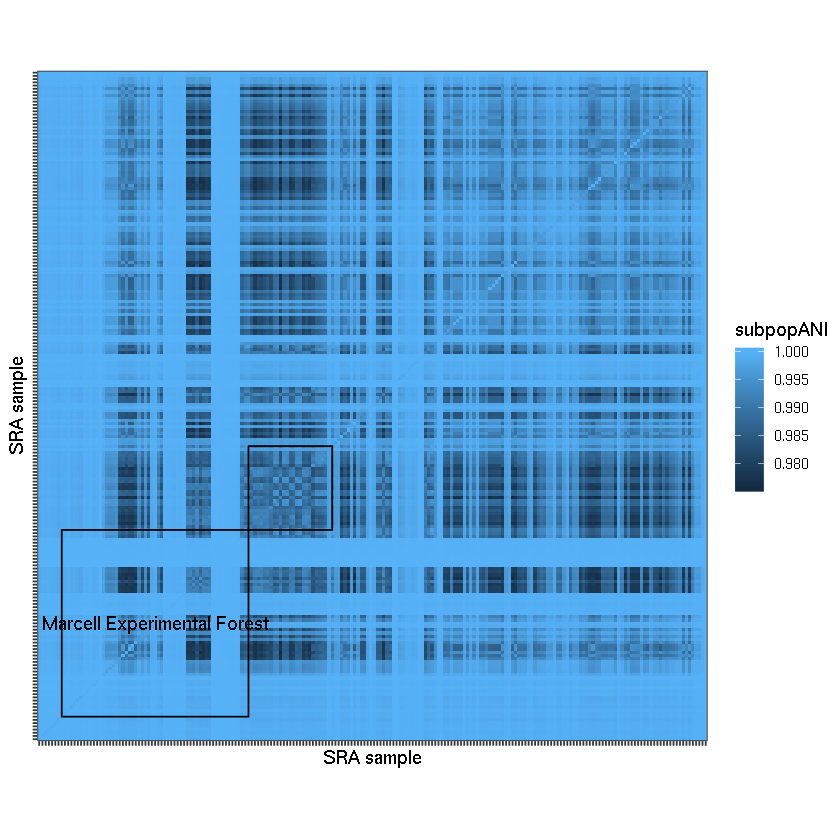

In [322]:
sub_pop_ani_melt <- melt(as.matrix((sub_pop_ani[,-1,with=FALSE])))
# con_ani_melt$Var1 <- factor(con_ani_melt$Var1)
ggplot(data=sub_pop_ani_melt, aes(x=factor(Var1), y=factor(Var2), fill=value)) +
    geom_tile() +
    scale_fill_gradient(name="subpopANI") +
    theme(
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
    ) +
    annotate("rect", ymin=66, xmin=66, ymax=92, xmax=92, alpha=1, linetype=1, color="black", fill=NA) +
    annotate("rect", ymin=8, xmin=8, ymax=66, xmax=66, alpha=1, linetype=1, color="black", fill=NA) + 
    annotate("text", y=37, x=37, alpha=1, color="black", label="Marcell Experimental Forest") +
    ylab("SRA sample") +
    xlab("SRA sample") +
    coord_fixed()

In [321]:
tmp <-heatmaply(sub_pop_ani[, -1, with=FALSE],
                  xlab = "Sample Name",
                  ylab = "Sample Name",
                  labRow = joined_con_ani[!is.na(V1)]$sample_name_fixed,
                  labCol = joined_con_ani[!is.na(V1)]$sample_name_fixed,
                  file = "/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/sub_pop_ani_heatmap.html",
                  k_row = 1, k_col = 1, plot_method="ggplot")

Warning message in fix_not_all_unique(rownames(x)):
“Not all the values are unique - manually added prefix numbers”Warning message in fix_not_all_unique(colnames(x)):
“Not all the values are unique - manually added prefix numbers”

Warning message in melt.data.table(strain_abundances):
“To be consistent with reshape2's melt, id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [strainID]. Consider providing at least one of 'id' or 'measure' vars in future.”

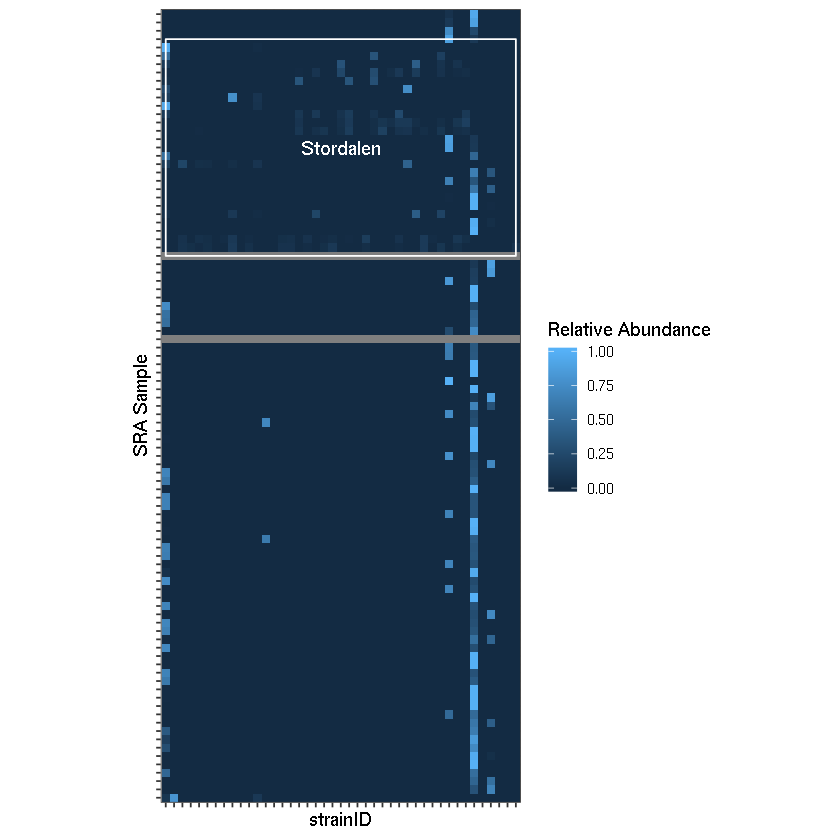

In [289]:

ggplot(data=melt(strain_abundances), aes(x=strainID, y=factor(variable), fill=value)) +
    geom_tile() +
    scale_fill_gradient(name="Relative Abundance") +
    ylab("SRA Sample") +
    theme(
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        ) +
    annotate("rect", ymin=66, xmin=1, ymax=92, xmax=43, alpha=1, linetype=1, color="white", fill=NA) +
    annotate("text", y=79, x=22, alpha=1, color="white", label="Stordalen") +
    coord_fixed()
    

In [304]:
pop_ani_1 <- fread("/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03-lorikeet_out/GCA_003141075.1_20120800_S1D_genomic/GCA_003141075.1_20120800_S1D_genomic_population_ani.tsv", skip="SampleID",)
con_ani_1 <- fread("/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03-lorikeet_out/GCA_003141075.1_20120800_S1D_genomic/GCA_003141075.1_20120800_S1D_genomic_consensus_ani.tsv", skip="SampleID")
sub_pop_ani_1 <- fread("/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03-lorikeet_out/GCA_003141075.1_20120800_S1D_genomic/GCA_003141075.1_20120800_S1D_genomic_subpopulation_ani.tsv", skip="SampleID",)

pop_ani_2 <- fread("/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03-lorikeet_out/GCA_003156255.1_20120600_S2D_genomic/GCA_003156255.1_20120600_S2D_genomic_population_ani.tsv", skip="SampleID",)
con_ani_2 <- fread("/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03-lorikeet_out/GCA_003156255.1_20120600_S2D_genomic/GCA_003156255.1_20120600_S2D_genomic_consensus_ani.tsv", skip="SampleID")
sub_pop_ani_2 <- fread("/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/03-lorikeet_out/GCA_003156255.1_20120600_S2D_genomic/GCA_003156255.1_20120600_S2D_genomic_subpopulation_ani.tsv", skip="SampleID",)


In [305]:
con_ani_1[, SampleID:=factor(SampleID)]
joined_con_ani_1 <- full_join(con_ani_1, full_metadata, by=c("SampleID"))
joined_con_ani_1[, sample_name_fixed := ifelse(is.na(sample_name), V1, sample_name)]
# joined_con_ani$sample_name_fixed
tmp <-heatmaply(con_ani_1[, -1, with=FALSE],
                  xlab = "Sample Name",
                  ylab = "Sample Name",
                  labRow = joined_con_ani_1[!is.na(V1)]$sample_name_fixed,
                  labCol = joined_con_ani_1[!is.na(V1)]$sample_name_fixed,
                  file = "/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/GCA_003141075.1_20120800_S1D_genomic_con_ani_heatmap.html",
                  k_row = 1, k_col = 1, plot_method="ggplot")

con_ani_2[, SampleID:=factor(SampleID)]
joined_con_ani_2 <- full_join(con_ani_2, full_metadata, by=c("SampleID"))
joined_con_ani_2[, sample_name_fixed := ifelse(is.na(sample_name), V1, sample_name)]
# joined_con_ani$sample_name_fixed
tmp <-heatmaply(con_ani_2[, -1, with=FALSE],
                  xlab = "Sample Name",
                  ylab = "Sample Name",
                  labRow = joined_con_ani_2[!is.na(V1)]$sample_name_fixed,
                  labCol = joined_con_ani_2[!is.na(V1)]$sample_name_fixed,
                  file = "/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/02-mflorens_variant_test/GCA_003156255.1_20120600_S2D_genomic_con_ani_heatmap.html",
                  k_row = 1, k_col = 1, plot_method="ggplot")

Warning message in `[.data.table`(joined_con_ani_1, , `:=`(sample_name_fixed, ifelse(is.na(sample_name), :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”Warning message in fix_not_all_unique(rownames(x)):
“Not all the values are unique - manually added prefix numbers”Warning message in fix_not_all_unique(colnames(x)):
“Not all the values are unique - manually added prefix numbers”Warning message in `[.data.table`(joined_con_ani_2, , `:=`(sample_name_fixed, ifelse(is.na(sample_nam